# **The NBA Data Playbook: Unraveling the Secrets of Success**



---






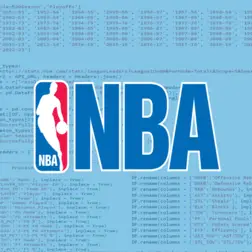

**Team Members**: Ali Saadeddine, Bennett Blanco, Riris Grace, Saumya Anand, Sulaiman Alhomoud, Ya Chu Hsu

**Instantiating Authentification**

In [ ]:
from google.colab import auth
auth.authenticate_user()

# Table of Contents



1.   Problem Definition
2.   Executive Summary
3.   Entity Relationship Diagram
4.   Introduction, Motivation, and Importance of the project
5.   Data Source
6.   Data cleaning and preparation
7.   Exploratory Data Analysis
8.   Key Findings & Conclusion
9.   References
10.  Data Dictionaries *(Lots of tables, so it is appended)*

# Problem Definition
The NBA is the pinnacle of basketball, bringing together the best talent from around the world. It is also notorious for being very player-stats-driven, which often influences the decision-making of coaching and teams. Our goal is to analyze data for players, coaches, and organizations within the NBA to get a data-driven understanding of how all of these actors interact. For the scope of this project, we’ll look at what drives the financial performance of organizations, as well as how player and team performance has affected wins/losses throughout the history of the league.
<br/>
<br/>

Each actor within the NBA will be able to realize value from this analysis. A better understanding of how each actor interacts with each other can help opponents strategize for upcoming games, guide organizations to make data-driven financial decisions, or influence decision-making in sports betting.


# Executive Summary

The comprehensive analysis of NBA player performance, team dynamics, and financial trends reveals several key insights. Kevin Durant stands out as the scoring leader, emphasizing the dominance of top-tier players in the current era. LeBron James, despite lacking formal collegiate education, emerges as the highest-paid player. The correlation between top contributors and high scorers underscores the significance of offensive prowess over assists. Defensive prowess is exemplified by DeAndre Jordan, while successful coaching performances by legends like Steve Kerr and Phil Jackson are highlighted. Team-wise, the Los Angeles Lakers demonstrate consistent excellence, while fan engagement, reflected in attendance, is notably strong for teams like the Chicago Bulls. The timing of games at 8:00 pm correlates with higher scores, indicating more exciting matchups. Additionally, the analysis sheds light on the evolving landscape of player salaries over the years, reflecting the impact of inflation.

# Entity Relationship Diagram

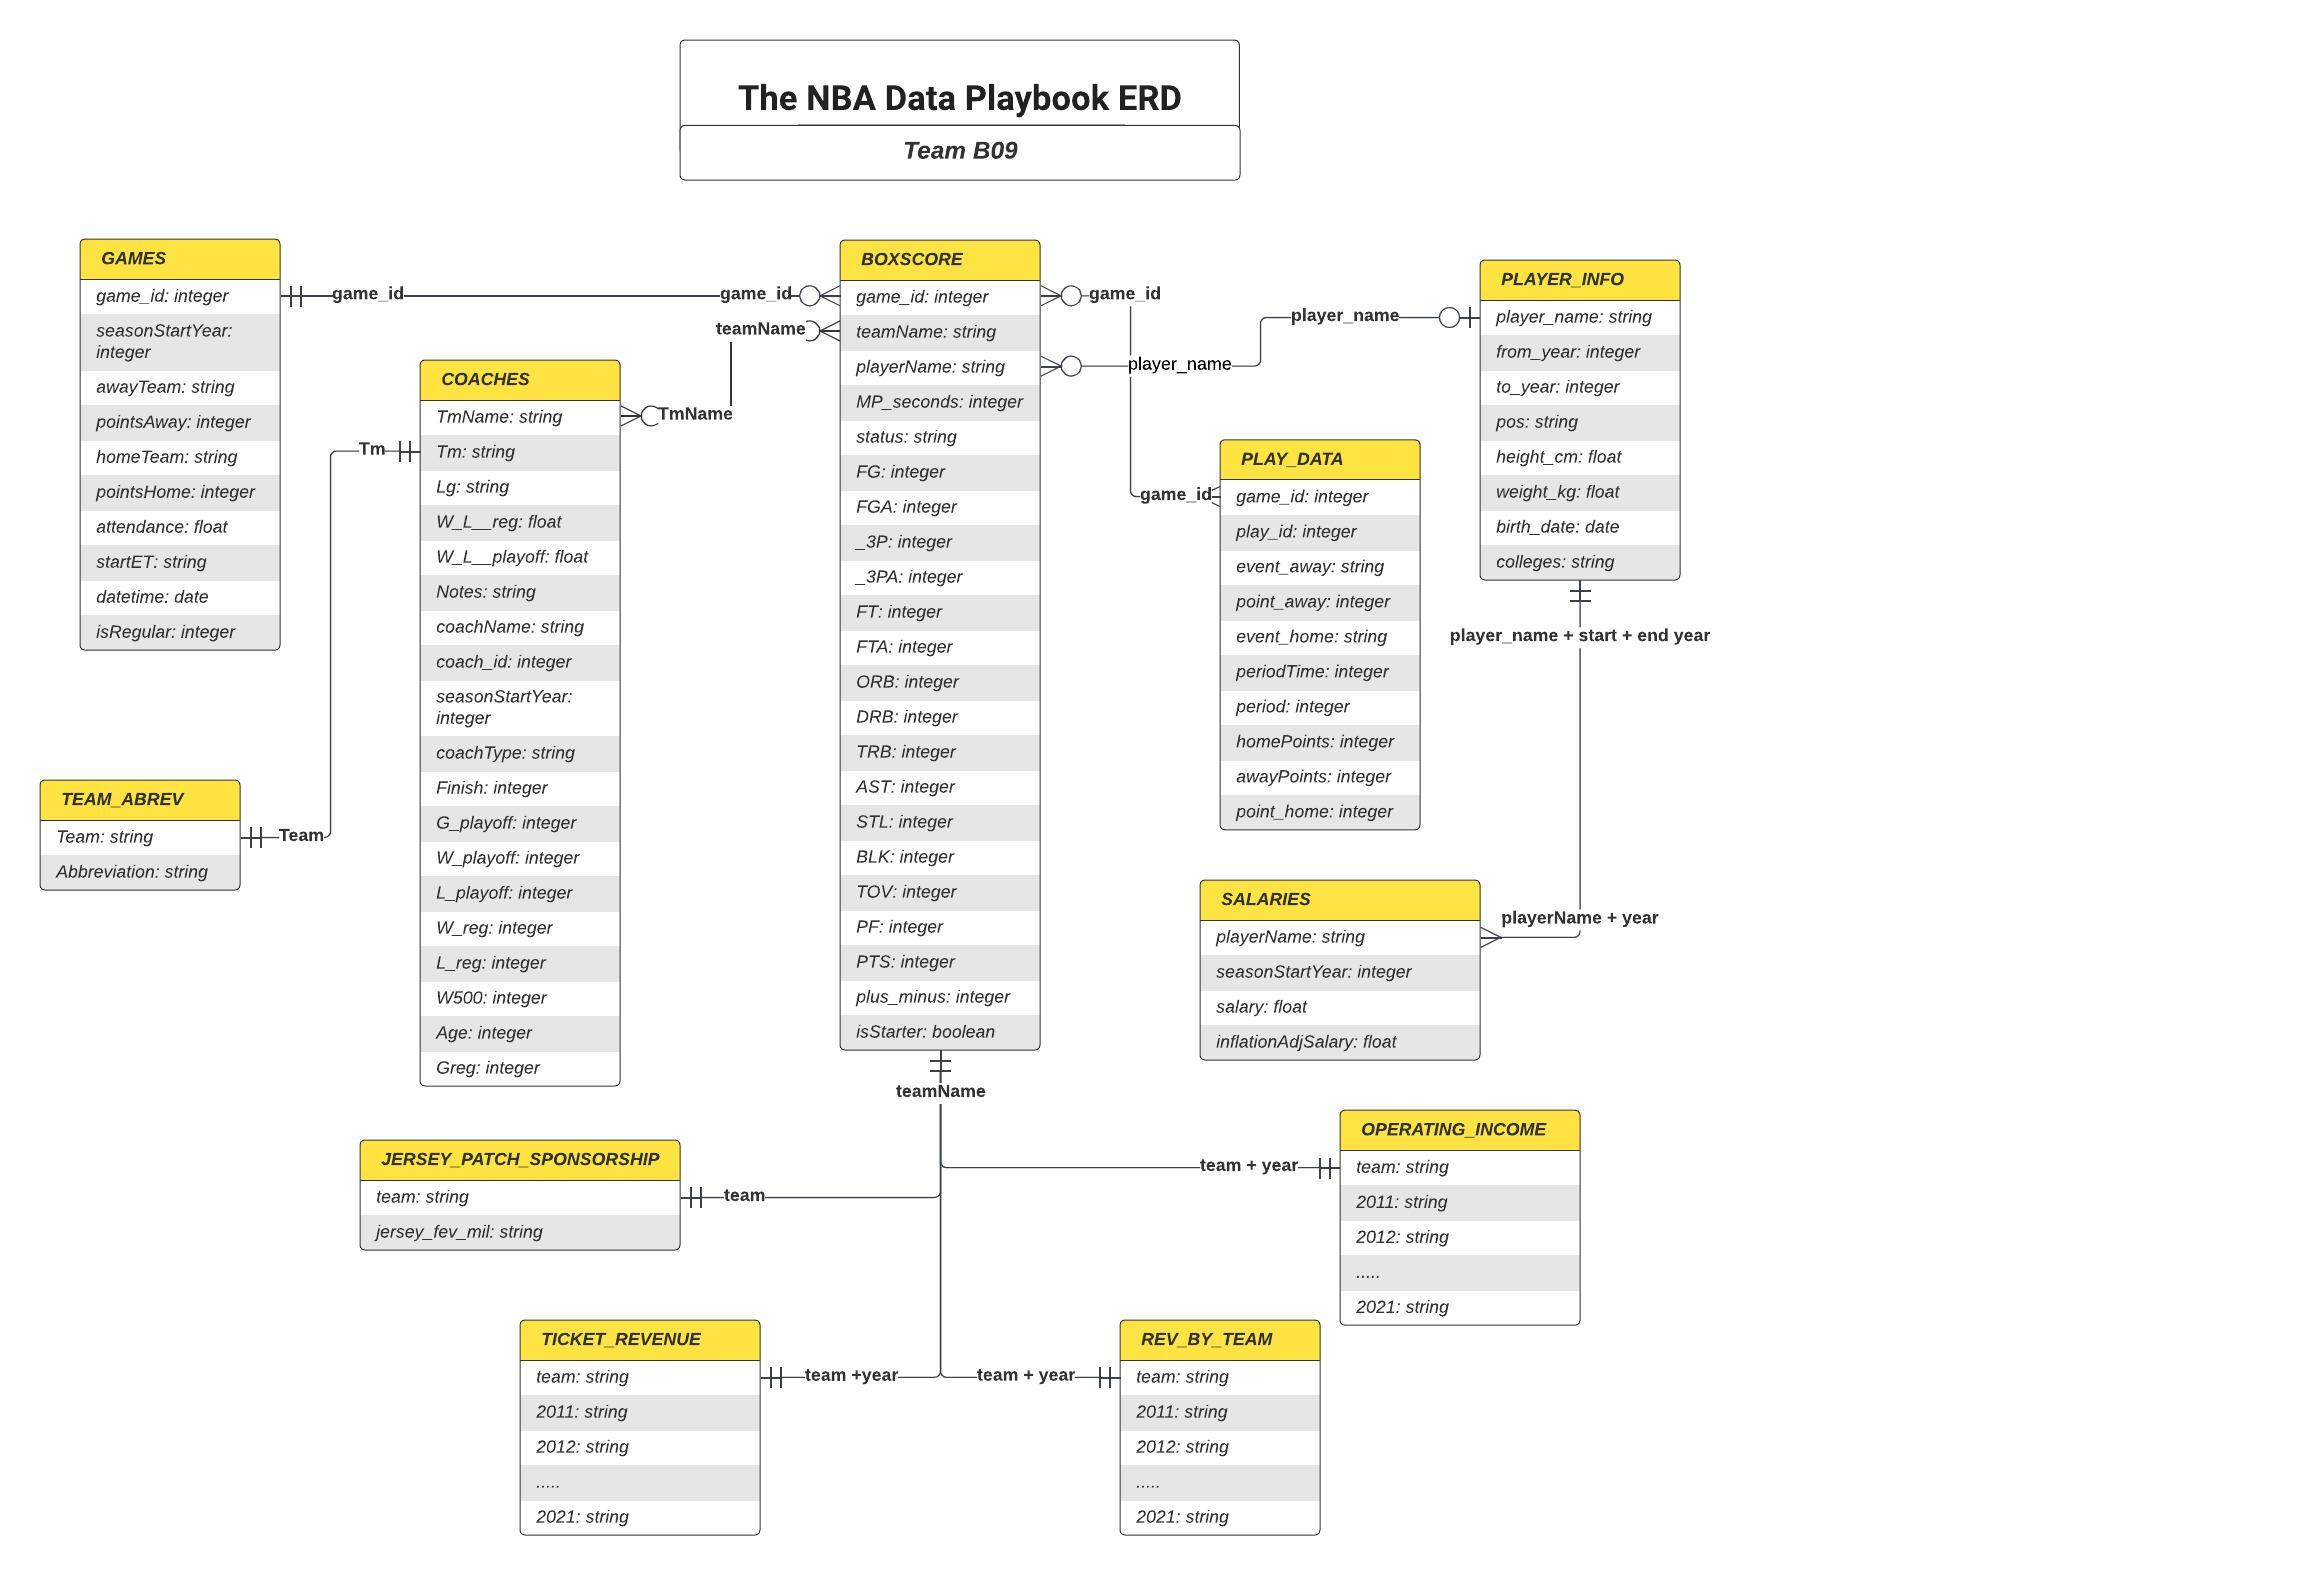

The ERD for the NBA Data Playbook have the interconnections among 11 tables, encapsulating various facets of NBA data, including Players, Teams, Games, Scores, and Financials. Games are associated with teams and their respective coaches, while players are connected to their performance data and salary details. Revenue streams are traced to teams across multiple years. Each game record is linked to specific team and coaching information, and player profiles are correlated with individual game statistics and financial data.The relationships between tables vary, encompassing one-to-one, one-to-many, and many-to-many associations. This data amalgamation provides comprehensive insights necessary for analyzing NBA games and unveiling interesting insights as described in Exploratory Data Analysis (EDA).

# Introduction, Motivation, and Importance of the Project

Embarking on a data analysis project focused on the NBA is fueled by the vast and intricate web of information surrounding players, coaches, and organizations within the league. The motivation behind delving into this trove of data lies in the profound impact it can have across various domains. By unraveling the interplay between players, coaches, and organizations, a clearer understanding emerges, enabling opponents to craft strategic game plans that cater to specific strengths and weaknesses. Moreover, this wealth of information can serve as a compass for organizations, steering them toward data-driven financial decisions that optimize player acquisitions, contract negotiations, and overall team management. Beyond the court, the insights derived from data analysis can also play a pivotal role in the realm of sports betting, providing enthusiasts with a well-informed basis for decision-making. In essence, the motivation behind this NBA data analysis project lies in its potential to revolutionize how we perceive, strategize, and engage with the dynamic world of professional basketball.

# Data Sources

* Web-scraped results of NBA data from https://www.basketball-reference.com/ available on Kaggle
https://www.kaggle.com/datasets/patrickhallila1994/nba-data-from-basketball-reference?select=games.csv
*  Financial data web-scraped from
https://runrepeat.com/nba-revenue-statistics
* so far ununsed --> https://www.spotrac.com/nba/

# Data Cleaning and Preparation

### Constructing an ELT pipeline for Financial Data

Collecting data from [runrepeat](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Frunrepeat.com%2Fnba-revenue-statistics) requires three things.
- We need to parse through the html code with BeautifulSoup and convert the html table content into dataframes.
- We have to create a service account in IAM & Admin, give the appropriate permissions, and then load the JSON key into our web scraping script
- Then we can load the results into the BigQuery project using the google cloud API to load a job.

This will be and ELT process since we're just going to set the entire schema to `String`. Once the data is in, we can make the proper adjustments. The pipeline script can be found [here](https://github.com/jbblancojr/nba_dashboard/blob/main/runrepeat_scrape.ipynb).

### Loading and Cleaning Webscraped Data

Each webscraped table contains a column for NBA teams, and then year columns from 2011-2021. However, each year represents the same metric. To tidy this up we need to unpivot the columns. The process is similar for our three tables. Additionally, `operating_income` and `revenue` are measured in millions, so we'll make that adjustment as well.

**`operating_income`**

In [ ]:
%%bigquery --project= teamb09
CREATE OR REPLACE TABLE `teamb09.web_scrape.operating_income_cleaned` AS (
  WITH loaded AS (
    SELECT Team AS team, CAST(year AS STRING) AS year, REGEXP_REPLACE(operating_income, '[$,]', ' ') as operating_income
    FROM teamb09.web_scrape.operating_income
    UNPIVOT (
      operating_income FOR year IN (`2011`, `2012`, `2013`, `2014`, `2015`, `2016`, `2017`, `2018`, `2019`, `2020`, `2021`)
    )
  )

  SELECT team, year, CAST((CAST(REPLACE(operating_income, ' ', '') AS INT64) * 1000000) AS NUMERIC) AS operating_income
  FROM loaded
);

Query is running:   0%|          |

""


**`revenue`**

In [ ]:
%%bigquery --project= teamb09
CREATE OR REPLACE TABLE `teamb09.web_scrape.revenue_cleaned` AS (
  WITH loaded AS (
    SELECT Team AS team, CAST(year AS STRING) AS year, REGEXP_REPLACE(revenue, '[$,]', ' ') as revenue
    FROM teamb09.web_scrape.rev_by_team
    UNPIVOT (
      revenue FOR year IN (`2011`, `2012`, `2013`, `2014`, `2015`, `2016`, `2017`, `2018`, `2019`, `2020`, `2021`)
    )
  )

  SELECT team, year, CAST((CAST(REPLACE(revenue, ' ', '') AS INT64) * 1000000) AS NUMERIC) AS revenue
  FROM loaded
);

Query is running:   0%|          |

""


**`ticket_rev`**

In [ ]:
%%bigquery --project= teamb09
CREATE OR REPLACE TABLE `teamb09.web_scrape.ticket_rev_cleaned` AS (
  WITH loaded AS (
    SELECT Team AS team, CAST(year AS STRING) AS year, REGEXP_REPLACE(revenue, '[$,]', ' ') as revenue
    FROM teamb09.web_scrape.rev_by_team
    UNPIVOT (
      revenue FOR year IN (`2011`, `2012`, `2013`, `2014`, `2015`, `2016`, `2017`, `2018`, `2019`, `2020`, `2021`)
    )
  )

  SELECT team, year, CAST((CAST(REPLACE(revenue, ' ', '') AS INT64) * 1000000) AS NUMERIC) AS revenue
  FROM loaded
);

Query is running:   0%|          |

""


### Cleaning Kaggle Data

**`boxscore`**

A major issue with the table `boxscore` is that stats columns for players, such as `STL` can contain `String` values if a player didn't play for a certain reason. We can use CASE to build out a `status` column that will map these values to a new column, and then we can leave the stats values as NULL so we don't skew the data when we aggregate these columns.

In [ ]:
%%bigquery --project= teamb09
CREATE OR REPLACE TABLE teamb09.kaggle.boxscore_cleaned AS
SELECT
  game_id,
  teamName,
  playerName,

  CASE
    WHEN MP = 'Did Not Play' OR MP = 'Did Not Dress' THEN NULL
    WHEN MP = 'Not With Team' OR MP = 'Player Suspended' THEN NULL
    ELSE CAST(SPLIT(MP, ':')[OFFSET(0)] AS INT64) * 60 + CAST(SPLIT(MP, ':')[OFFSET(1)] AS INT64)
  END AS MP_seconds,

## Creating a status column

  CASE
    WHEN FG = 'Not With Team' OR FGA = 'Not With Team' OR _3P = 'Not With Team' OR
         _3PA = 'Not With Team' OR FT = 'Not With Team' OR FTA = 'Not With Team' OR
         ORB = 'Not With Team' OR DRB = 'Not With Team' OR TRB = 'Not With Team' OR
         AST = 'Not With Team' OR STL = 'Not With Team' OR BLK = 'Not With Team' OR
         TOV = 'Not With Team' OR PF = 'Not With Team' OR PTS = 'Not With Team' THEN 'Not With Team'

    WHEN FG = 'Did Not Dress' OR FGA = 'Did Not Dress' OR _3P = 'Did Not Dress' OR
         _3PA = 'Did Not Dress' OR FT = 'Did Not Dress' OR FTA = 'Did Not Dress' OR
         ORB = 'Did Not Dress' OR DRB = 'Did Not Dress' OR TRB = 'Did Not Dress' OR
         AST = 'Did Not Dress' OR STL = 'Did Not Dress' OR BLK = 'Did Not Dress' OR
         TOV = 'Did Not Dress' OR PF = 'Did Not Dress' OR PTS = 'Did Not Dress' THEN 'Did Not Dress'

    WHEN FG = 'Did Not Play' OR FGA = 'Did Not Play' OR _3P = 'Did Not Play' OR
         _3PA = 'Did Not Play' OR FT = 'Did Not Play' OR FTA = 'Did Not Play' OR
         ORB = 'Did Not Play' OR DRB = 'Did Not Play' OR TRB = 'Did Not Play' OR
         AST = 'Did Not Play' OR STL = 'Did Not Play' OR BLK = 'Did Not Play' OR
         TOV = 'Did Not Play' OR PF = 'Did Not Play' OR PTS = 'Did Not Play' THEN 'Did Not Play'

    WHEN FG = 'Player Suspended' OR FGA = 'Player Suspended' OR _3P = 'Player Suspended' OR
         _3PA = 'Player Suspended' OR FT = 'Player Suspended' OR FTA = 'Player Suspended' OR
         ORB = 'Player Suspended' OR DRB = 'Player Suspended' OR TRB = 'Player Suspended' OR
         AST = 'Player Suspended' OR STL = 'Player Suspended' OR BLK = 'Player Suspended' OR
         TOV = 'Player Suspended' OR PF = 'Player Suspended' OR PTS = 'Player Suspended' THEN 'Player Suspended'

    ELSE 'Played'
  END AS status,

-- Clean statistical columns, converting to INT64 and handle non-numeric statuses
  CASE WHEN FG IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(FG AS INT64) END AS FG,
  CASE WHEN FGA IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(FGA AS INT64) END AS FGA,
  CASE WHEN _3P IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(_3P AS INT64) END AS ThreeP,
  CASE WHEN _3PA IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(_3PA AS INT64) END AS ThreePA,
  CASE WHEN FT IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(FT AS INT64) END AS FT,
  CASE WHEN FTA IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(FTA AS INT64) END AS FTA,
  CASE WHEN ORB IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(ORB AS INT64) END AS ORB,
  CASE WHEN DRB IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(DRB AS INT64) END AS DRB,
  CASE WHEN TRB IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(TRB AS INT64) END AS TRB,
  CASE WHEN AST IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(AST AS INT64) END AS AST,
  CASE WHEN STL IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(STL AS INT64) END AS STL,
  CASE WHEN BLK IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(BLK AS INT64) END AS BLK,
  CASE WHEN TOV IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(TOV AS INT64) END AS TOV,
  CASE WHEN PF IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(PF AS INT64) END AS PF,
  CASE WHEN PTS IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL ELSE CAST(PTS AS INT64) END AS PTS,

CAST(
  CASE
    WHEN `___` IN ('Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended') THEN NULL
    ELSE NULLIF(REGEXP_REPLACE(`___`, r'[^0-9-+]', ''), '')
  END AS INT64
) AS plus_minus,

  CAST(isStarter AS BOOLEAN) AS isStarter
FROM
  `teamb09.kaggle.boxscore`;

Query is running:   0%|          |

""


**`coaches`**

In the `coaches` table, the following columns were classified as `float`:
* Age
* G_reg
* W_reg
* L_reg
* W_500
* Finish
* G_playoff
* W_playoff
* L-playoff

Their data type should be `int`, as they only contain numeric values.

The data type of each columns were changed accordingly. Next, missing values were handled, as there were nulls in G_playoff, W_playoff, L_playoff, W_L_playoff. We imputed these nulls with 0, as not every team makes the playoffs (resulting in null values)

Additionally, the `notes` column is actually in reference to how far a team made it in the playoffs. Since the only values are conference champions (east or west) and NBA champions, there are a lot of null values because only 2 of 32 teams can obtain this status every season. The nulls can stay, and the name will be switched from `notes` to `accolade`.



In [ ]:
%%bigquery --project= teamb09
CREATE OR REPLACE TABLE `teamb09.kaggle.coaches_updated` AS (
  SELECT
    coach_id,
    coachName AS name,
    coachType AS role,
    CAST(Age AS INT64) AS age,
    Lg AS league,
    CAST(G_reg AS INT64) AS regular_games_coached,
    CAST(W_reg AS INT64) AS regular_season_wins,
    CAST(L_reg AS INT64) AS regular_season_losses,
    W_L__reg AS reagular_winloss_ratio,
    CAST(W____500 AS INT64) AS games_from_500,
    CAST(Finish AS INT64) AS season_rank,
    CAST(G_playoff AS INT64) AS playoff_games_coached,
    CAST(W_playoff AS INT64) AS playoff_wins,
    CAST(L_playoff AS INT64) AS playoff_losses,
    W_L__playoff AS playoff_winloss_ratio,
    Notes as accolade,
    CASE
        WHEN coach.Tm = 'SEA' THEN 'Seattle Supersonics'
        WHEN coach.Tm = 'KEN' THEN 'Kentucky Colonels'
        WHEN coach.Tm = 'NJN' THEN 'New Jersey Nets'
        WHEN coach.Tm = 'PHO' THEN 'Phoenix Suns'
        WHEN coach.Tm = 'KCK' THEN 'Kansas City Kings'
        WHEN coach.Tm = 'BRK' THEN 'Brooklyn Nets'
        WHEN coach.Tm = 'WSB' THEN 'Washington Bullets'
        WHEN coach.Tm = 'VAN' THEN 'Vancouver Grizzlies'
        WHEN coach.Tm = 'NOH' THEN 'New Orleans Hornets'
        WHEN coach.Tm = 'CHH' THEN 'Charlotte Hornets'
        WHEN coach.Tm = 'SDC' THEN 'San Diego Clippers'
        WHEN coach.Tm = 'NOK' THEN 'New Orleans/Okalhoma City Hornets'
        WHEN coach.Tm = 'CHO' THEN 'Charlotte Hornets'
        WHEN coach.Tm = 'BUF' THEN 'Buffalo Braves'
        WHEN coach.Tm = 'CAR' THEN 'Carolina Cougars'
        WHEN coach.Tm = 'STL' THEN 'St. Louis Hawks'
        WHEN coach.Tm = 'DNA' THEN 'Denver Nuggets'
        ELSE abr.Abbreviation
    END AS Team
  FROM `kaggle.Coaches-Original` as coach
  LEFT JOIN `teamb09.web_scrape.team_abrev` as abr
  ON coach.Tm = abr.Team
);

Query is running:   0%|          |

""


**`games`**

The game table is fairly clean to begin with. The only exception is that the notes column here refers to special cases for a specific game. For example, if a game was played outside of the United States for a special event. This rarely happens, and doesn't affect anything else about how the game is played. We can just drop the column.

In [ ]:
%%bigquery --project= teamb09
ALTER TABLE `teamb09.kaggle.games`
DROP COLUMN notes;

Executing query with job ID: 8e6e0d75-ae88-495e-bd09-f04eb634403f
Query executing: 0.56s


ERROR:
 400 Column not found: notes at [2:13]

Location: US
Job ID: 8e6e0d75-ae88-495e-bd09-f04eb634403f



**`player_info`**

A major issue with the `player_info` table is the lack of standardized measurements. Additionally the `birthDate` for each player is formatted as `string`.

Below are the converted fields:

- Height (from feet and inches to cm),
- Weight (from pounds to kg),
- Birthdate (from string to date format).

Additionally, there are instances of duplicate names in the table which actually represent different individuals. Therefore, when using the relationship between tables, we need to include the year to accurately identify players. This covers all the instances, because it is one of two cases:
- a duplicate player is a father and son, who played at different times
- the players actually have the same name, but are on different teams

In [ ]:
%%bigquery --project= teamb09
--check duplicate player by all column
SELECT playerName, `From`, `To`, Pos, Ht, Wt, birthDate, colleges, count(*) repeat FROM teamb09.kaggle.player_info
GROUP BY playerName, `From`, `To`, Pos, Ht, Wt, birthDate, colleges
HAVING repeat > 1;

--check duplicate player by playerName only
CREATE OR REPLACE TABLE `teamb09.temp.player_info_duplicate`
AS
SELECT playerName, count(*) repeat FROM `teamb09.kaggle.player_info`
GROUP BY playerName
HAVING repeat > 1;

--check duplicate player by playerName and college
CREATE OR REPLACE TABLE `teamb09.temp.player_info_duplicate2`
AS
SELECT playerName,colleges, count(*) repeat FROM `teamb09.kaggle.player_info`
GROUP BY playerName, colleges
HAVING repeat > 1;

--create new table with convertion in height (from feet and inches to cm), weight (from pounds to kg), and birthdate (from string to date)
CREATE OR REPLACE TABLE `teamb09.kaggle.player_info_cleaned`
AS
SELECT
  playerName AS player_name,
  `From` AS from_year,
  `To` AS to_year,
  Pos AS pos,
  ROUND(((CAST((SPLIT(Ht, '-')[OFFSET(0)]) AS INT64 ) * 12) + CAST((SPLIT(Ht, '-')[OFFSET(1)] ) AS INT64)) * 2.54,2) AS height_cm,
  ROUND(Wt*0.45359237,2) AS weight_kg,
  PARSE_DATE('%B %d, %Y', birthDate) as birth_date,
  Colleges as colleges
FROM `teamb09.kaggle.player_info`;

Query is running:   0%|          |

""


**`salaries`**

The only issue with the `salaries` table, is that the data is loaded in as string due to the $ character. With some casting and replacing, this is easily resolved.

In [ ]:
%%bigquery --project= teamb09
CREATE OR REPLACE TABLE teamb09.kaggle.salaries_cleaned AS
SELECT
  playerName,
  seasonStartYear,
  CAST(REPLACE(REPLACE(CAST(salary AS STRING), '$', ''), ',', '') AS FLOAT64) AS salary,
  CAST(REPLACE(REPLACE(CAST(inflationAdjSalary AS STRING), '$', ''), ',', '') AS FLOAT64) AS inflationAdjSalary
FROM
  teamb09.kaggle.salaries;

Query is running:   0%|          |

""


### Creating a Per Game Stats Table

In general, NBA players are typically evaluated on the per game stats. Since the data we have contains stat lines by specific games, we need to group players game stats by name, team, and season. Then we'll take the average of each group (player in a given season) to get their per game stats. Saving this as a view will be useful for conducting further analyses at this level.

In [ ]:
%%bigquery --project= teamb09
CREATE OR REPLACE VIEW `teamb09.kaggle.per_game_stats` AS (
  WITH player_stats AS (
    SELECT
      bs.game_id, bs.playerName AS Player, bs.teamName AS Team, -- Info and Player Name
      g.seasonStartYear AS Season, g.awayTeam AS Opponent, -- Year and Opposing Team
      bs.PTS AS Points, bs.AST AS Assists, bs.TRB AS Total_Rebounds, bs.STL AS Steals, bs.BLK AS Blocks, bs.TOV AS Turnovers, bs.PF AS Personal_Fouls, bs.FG, bs.FGA, bs.FT, bs.FTA, bs.ThreeP, bs.ThreePA, -- Player Stats
      CASE
        WHEN bs.FGA = 0 THEN NULL
        ELSE ROUND(bs.FG / bs.FGA, 2)
        END AS FG_Pct, -- Getting field goal %
      CASE
        WHEN bs.FTA = 0 THEN NULL
        ELSE ROUND(bs.FT / bs.FTA, 2)
        END AS FT_Pct, -- Getting free throw goal %
      CASE
        WHEN bs.ThreeP = 0 THEN NULL
        ELSE ROUND(bs.ThreeP / bs.ThreePA, 2)
        END AS Three_Pct, -- Getting 3ptr %
      CASE
        WHEN bs.MP_seconds = 0 THEN NULL
        ELSE ROUND(bs.MP_seconds / 60, 2)
        END AS MPG,
      bs.plus_minus
    FROM `teamb09.kaggle.boxscore_cleaned` AS bs
    INNER JOIN `teamb09.kaggle.games` AS g
    USING(game_id)
  )
  SELECT Player, Team, Season, ROUND(AVG(Points), 1) AS PPG, ROUND(AVG(Assists), 1) AS APG, ROUND(AVG(Total_Rebounds), 1) AS RPG, ROUND(AVG(Steals), 1) AS SPG, ROUND(AVG(Blocks), 1) AS BPG, ROUND(AVG(Turnovers), 1) AS TPG,
  ROUND(SUM(FG) / NULLIF(SUM(FGA), 0), 2) AS FGP,
  ROUND(SUM(FT) / NULLIF(SUM(FTA), 0), 2) AS FTP,
  ROUND(SUM(ThreeP) / NULLIF(SUM(ThreePA), 0), 2) AS ThreePP
  FROM player_stats
  GROUP BY Player, Team, Season
);

Query is running:   0%|          |

""


No charts were generated by quickchart


# Exploratory Data Analysis

## Player Analysis

**What are each players relative stats?**

To see how players are performing relative to the league in a given season, we can compare a players per game stats to the league average in a given season. Players with positive relative stats are "better" than the average player in a given season, and vice versa if they have negative values.

In [ ]:
%%bigquery --project= teamb09
SELECT
  pgs.Player, pgs.Team, pgs.Season, pi.pos,
  ROUND(pgs.PPG - AVG(pgs.PPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_PPG,
  ROUND(pgs.APG - AVG(pgs.APG) OVER(PARTITION BY pgs.Season), 1) AS Relative_APG,
  ROUND(pgs.RPG - AVG(pgs.RPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_RPG,
  ROUND(pgs.SPG - AVG(pgs.SPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_SPG,
  ROUND(pgs.BPG - AVG(pgs.BPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_BPG,
  ROUND(pgs.TPG - AVG(pgs.TPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_TPG,
  ROUND(pgs.PPG - AVG(pgs.PPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_PPG,
  ROUND(pgs.FGP - AVG(pgs.FGP) OVER(PARTITION BY pgs.Season), 1) AS Relative_FGP,
  ROUND(pgs.FTP - AVG(pgs.FTP) OVER(PARTITION BY pgs.Season), 1) AS Relative_FTP,
  ROUND(pgs.ThreePP - AVG(pgs.ThreePP) OVER(PARTITION BY pgs.Season), 1) AS Relative_ThreePP
FROM `teamb09.kaggle.per_game_stats` AS pgs
LEFT JOIN `teamb09.kaggle.player_info_cleaned` AS pi
ON pgs.Player = pi.player_name;

Query is running:   0%|          |

Downloading:   0%|          |

,Player,Team,Season,pos,Relative_PPG,Relative_APG,Relative_RPG,Relative_SPG,Relative_BPG,Relative_TPG,Relative_PPG_1,Relative_FGP,Relative_FTP,Relative_ThreePP
0,Larry Hughes,Golden State Warriors,2000,G,9.0,2.7,2.0,1.2,0.2,1.8,9.0,0.0,0.1,-0.1
1,Rod Strickland,Washington Wizards,2000,G,4.7,5.2,-0.3,0.6,-0.3,1.3,4.7,0.0,0.1,0.0
2,Toni Kukoč,Atlanta Hawks,2000,None,12.2,4.4,2.2,0.1,-0.1,1.8,12.2,0.1,0.0,0.2
3,Bob Sura,Golden State Warriors,2000,G,3.6,2.8,0.8,0.3,-0.2,1.8,3.6,0.0,0.0,0.0
4,Nick Van Exel,Denver Nuggets,2000,G,10.2,6.7,-0.1,0.2,-0.1,1.1,10.2,0.0,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,Reggie Slater,New Jersey Nets,2001,F,-6.5,-1.8,-3.0,-0.7,-0.4,-0.9,-6.5,0.6,0.3,NaN
10871,Charlie Bell,Dallas Mavericks,2001,G,-7.8,-1.8,-3.0,-0.7,-0.4,-1.2,-7.8,NaN,NaN,NaN
10872,Ernest Brown,Miami Heat,2001,C,-6.8,-1.8,-1.5,-0.7,-0.1,-0.2,-6.8,-0.3,-0.5,NaN
10873,Matt Geiger,Philadelphia 76ers,2001,C,-7.0,-1.8,-2.0,-0.7,0.1,-0.7,-7.0,-0.3,-0.2,NaN


**Top 5 Players with Highest Average Points Per Game (2010-2022)**



This query identifies the players with the highest scoring efficiency over the past decade. The way basketball is played is often changing every several years. So, this helps us see which are the most dominant scorers in the current state of the game.

In [ ]:
%%bigquery --project=teamb09

SELECT b.playerName, AVG(b.PTS) as avgPoints
FROM teamb09.kaggle.boxscore_cleaned AS b
JOIN teamb09.kaggle.games AS g ON b.game_id = g.game_id
WHERE g.seasonStartYear BETWEEN 2010 AND 2022
GROUP BY b.playerName
ORDER BY avgPoints DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,playerName,avgPoints
0,Kevin Durant,27.970509
1,LeBron James,26.954442
2,James Harden,26.253488
3,Russell Westbrook,25.066085
4,Stephen Curry,24.607387


The results show that Kevin Durant leads with the highest average points per game at `27.97`, followed by LeBron James, James Harden, Russell Westbrook, and Stephen Curry. This makes sense, given that these players are regarded as the most dominant in the current era.

**Which college basketball programs generate the highest average salary in the NBA?**

The reasoning behind the question is mainly insighful for upcoming 4 or 5 star recruits that know they'll be one and dones (enter the NBA draft after one season of college ball). These players typically chose from the places they're offered, so it might be helpful to see which generate the highest NBA returns, if money is an issue. Furthermore, we'll see how many alumni are in the NBA for each school.

In [ ]:
%%bigquery --project=teamb09
-- What university generate the highest salary on average?
  WITH rookies AS (
    SELECT playerName, MIN(seasonStartYear) Rookie_Season
    FROM kaggle.player_info_cleaned as pi
    LEFT JOIN kaggle.salaries_cleaned as sc
    ON pi.player_name = sc.playerName
    WHERE salary IS NOT NULL AND seasonStartYear BETWEEN from_year AND to_year
    GROUP BY playerName
  ),

  rookie_contracts AS (
    SELECT
      DISTINCT r.playerName,
      r.Rookie_Season,
      MIN(sc.salary) AS Starting_Salary,
      MAX(pi.colleges) AS colleges
    FROM
      rookies r
    LEFT JOIN
      `teamb09.kaggle.salaries_cleaned` sc
      USING(playerName)
    LEFT JOIN
      `teamb09.kaggle.player_info_cleaned` pi
    ON
      r.playerName = pi.player_name
    GROUP BY
      r.playerName, r.Rookie_Season
  )

  SELECT colleges, ROUND(AVG(Starting_Salary), 2) avg_starting_salary, COUNT(rookie_contracts.colleges) alumni
  FROM rookie_contracts
  GROUP BY colleges
  HAVING COUNT(colleges) > 10 -- removes outlies
  ORDER BY avg_starting_salary DESC

Query is running:   0%|          |

Downloading:   0%|          |

,colleges,avg_starting_salary,alumni
0,Duke,1697143.71,38
1,Alabama,1579037.93,15
2,Texas,1566146.47,17
3,Kentucky,1517124.29,51
4,Ohio State,1512539.31,13
5,Arizona,1487520.44,32
6,Illinois,1467066.00,12
7,California,1432654.27,15
8,Kansas,1431402.87,31
9,UNLV,1355984.45,11


From this we can infer the most reputable college basketball programs. We see that Duke players will generally have the highest salary, which checks out. They generally have the largest amount of high performing players (Kyrie Irving,Carlos Boozer, Shane Battier, JJ Reddick). From the count we'll see that UNC actually has the largest alumni base from our years of observation (42). As a prospect selecting a college, this may help you make a more informed decision. Do you want a higher salary going into the league? If offered a spot, go for the highest average school in your list. Maybe money is less of a concern and you'd rather just get to the league? Maybe the bigger alumni base will be more beneficial to you.

**Players with Highest Contribution in Points Scored and Assists (2010-2022)**


This query identifies players with the highest overall impact on the game through scoring and playmaking. It sums the total points and assists for each player. This should show similar results to the highest average scorers.

In [ ]:
%%bigquery --project=teamb09

SELECT b.playerName, SUM(b.PTS) + SUM(b.AST) AS totalContribution
FROM `teamb09.kaggle`.boxscore_cleaned AS b
JOIN `teamb09.kaggle`.games AS g ON b.game_id = g.game_id
WHERE g.seasonStartYear BETWEEN 2010 AND 2022
GROUP BY b.playerName
ORDER BY totalContribution DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,playerName,totalContribution
0,LeBron James,30321
1,James Harden,28273
2,Russell Westbrook,27025
3,Kevin Durant,24267
4,Stephen Curry,22841


LeBron James stands out as the top contributor with a total contribution score of `30,321`, followed by James Harden, Russell Westbrook, Kevin Durant, and Stephen Curry. These results are the exact same as the highest average scorers, which may suggest that assists don't carry as much wait when considering a players offensive prowess.

**Best Defensive Players (2010-2022)**


This query aims to identify the best defensive players by considering steals, blocks, and defensive rebounds. It provides a composite score based on these defensive metrics. With a better understanding of who is defensively the best player, teams with low defensive ratings can look to scout these players, or an upcoming opponent can strategize ahead of time to try and work around this player.

In [ ]:
%%bigquery --project=teamb09

SELECT b.playerName, SUM(b.STL) + SUM(b.BLK) + SUM(b.DRB) AS totalDefenseScore
FROM `teamb09.kaggle`.boxscore_cleaned AS b
JOIN `teamb09.kaggle`.games AS g ON b.game_id = g.game_id
WHERE g.seasonStartYear BETWEEN 2010 AND 2022
GROUP BY b.playerName
ORDER BY totalDefenseScore DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,playerName,totalDefenseScore
0,DeAndre Jordan,8644
1,LeBron James,7915
2,Dwight Howard,7592
3,Andre Drummond,7277
4,Kevin Durant,6775


DeAndre Jordan emerged as the top defensive player with a total defensive score of `8,644`, with LeBron James, Dwight Howard, Andre Drummond, and Kevin Durant completing the top five.

**Identifying Players with the Most Triple-Doubles Off the Bench in Regular Games**


This query aims to find the players with the most triple-doubles off the bench in regular games, this query allows us to see that there are reserve players with high potential, as evidenced by their ability to score triple-doubles even though they are not the main players.

In [ ]:
%%bigquery --project=teamb09
SELECT boxscore.*, games.datetime
FROM teamb09.kaggle.boxscore_cleaned AS boxscore
LEFT JOIN teamb09.kaggle.games ON boxscore.game_id = games.game_id
WHERE
    (((boxscore.PTS>=10 AND boxscore.TRB>=10 AND boxscore.AST>=10) OR
    (boxscore.PTS>=10 AND boxscore.TRB>=10 AND boxscore.STL>=10) OR
    (boxscore.PTS>=10 AND boxscore.TRB>=10 AND boxscore.BLK>=10) OR
    (boxscore.PTS>=10 AND boxscore.AST>=10 AND boxscore.STL>=10) OR
    (boxscore.PTS>=10 AND boxscore.AST>=10 AND boxscore.BLK>=10) OR
    (boxscore.PTS>=10 AND boxscore.STL>=10 AND boxscore.BLK>=10) OR
    (boxscore.TRB>=10 AND boxscore.AST>=10 AND boxscore.STL>=10) OR
    (boxscore.TRB>=10 AND boxscore.AST>=10 AND boxscore.BLK>=10) OR
    (boxscore.TRB>=10 AND boxscore.STL>=10 AND boxscore.BLK>=10) OR
    (boxscore.AST>=10 AND boxscore.STL>=10 AND boxscore.BLK>=10)) AND
    boxscore.isStarter = false)
ORDER BY games.datetime DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,game_id,teamName,playerName,MP_seconds,status,FG,FGA,ThreeP,ThreePA,FT,...,TRB,AST,STL,BLK,TOV,PF,PTS,plus_minus,isStarter,datetime
0,28966,Portland Trail Blazers,Evan Turner,1705,Played,6,7,1,1,0,...,12,11,0,0,2,1,13,21,False,2019-04-03
1,28951,Portland Trail Blazers,Evan Turner,1496,Played,5,5,1,1,2,...,11,10,1,0,1,1,13,15,False,2019-04-01
2,28521,Los Angeles Clippers,Lou Williams,1933,Played,9,19,2,6,11,...,10,10,1,1,3,0,31,3,False,2019-01-25
3,28041,New Orleans Pelicans,Julius Randle,1520,Played,9,13,0,1,3,...,14,10,1,0,0,2,21,12,False,2018-11-19
4,27702,Philadelphia 76ers,Markelle Fultz,1515,Played,6,13,0,0,1,...,10,10,2,1,2,0,13,18,False,2018-04-11
5,27669,Boston Celtics,Greg Monroe,1668,Played,8,10,0,0,3,...,11,10,2,1,3,4,19,4,False,2018-04-06
6,27326,Philadelphia 76ers,T.J. McConnell,2230,Played,5,11,0,0,0,...,10,11,6,0,2,4,10,11,False,2018-02-12
7,25531,New Orleans Pelicans,Tim Frazier,2276,Played,4,10,0,2,6,...,11,11,5,1,1,4,14,18,False,2016-12-11
8,24923,Orlando Magic,Elfrid Payton,2069,Played,9,21,0,3,2,...,10,10,1,0,1,3,20,-6,False,2016-03-23
9,24614,Miami Heat,Hassan Whiteside,1622,Played,4,8,0,0,2,...,10,0,0,10,2,4,10,8,False,2016-02-05


The results here are interesting, as this list consists of a lot of 6th MOTY recipients and highly valued role players. If a front office needs extra firepower going into the trade deadline, these are good players to look to trade for or sign if they happen to be free agents.

**Finding Players with Triple-Doubles but Fewer than 10 Points in NBA Games**



This query allows us to see one of the rarest triple-double achievements in the NBA with fewer than 10 points. A player achieves triple-doubles, but they have less than 10 points in the game.

In [ ]:
%%bigquery --project=teamb09
SELECT boxscore.*, games.datetime
FROM teamb09.kaggle.boxscore_cleaned AS boxscore
LEFT JOIN teamb09.kaggle.games ON boxscore.game_id = games.game_id
WHERE
    ((boxscore.TRB>=10 AND boxscore.AST>=10 AND boxscore.STL>=10) OR
    (boxscore.TRB>=10 AND boxscore.AST>=10 AND boxscore.BLK>=10) OR
    (boxscore.TRB>=10 AND boxscore.STL>=10 AND boxscore.BLK>=10) OR
    (boxscore.AST>=10 AND boxscore.STL>=10 AND boxscore.BLK>=10)) AND
    boxscore.PTS<10
ORDER BY games.datetime DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,game_id,teamName,playerName,MP_seconds,status,FG,FGA,ThreeP,ThreePA,FT,...,TRB,AST,STL,BLK,TOV,PF,PTS,plus_minus,isStarter,datetime
0,25975,Golden State Warriors,Draymond Green,2264,Played,2,6,0,3,0,...,11,10,10,5,2,3,4,26,True,2017-02-10


This is a fun insight, it doesn't provide much business value, but it is still an interesting find. The value from this stat line was related to the buzz and publicity that the league and Draymond Green got when this occured.

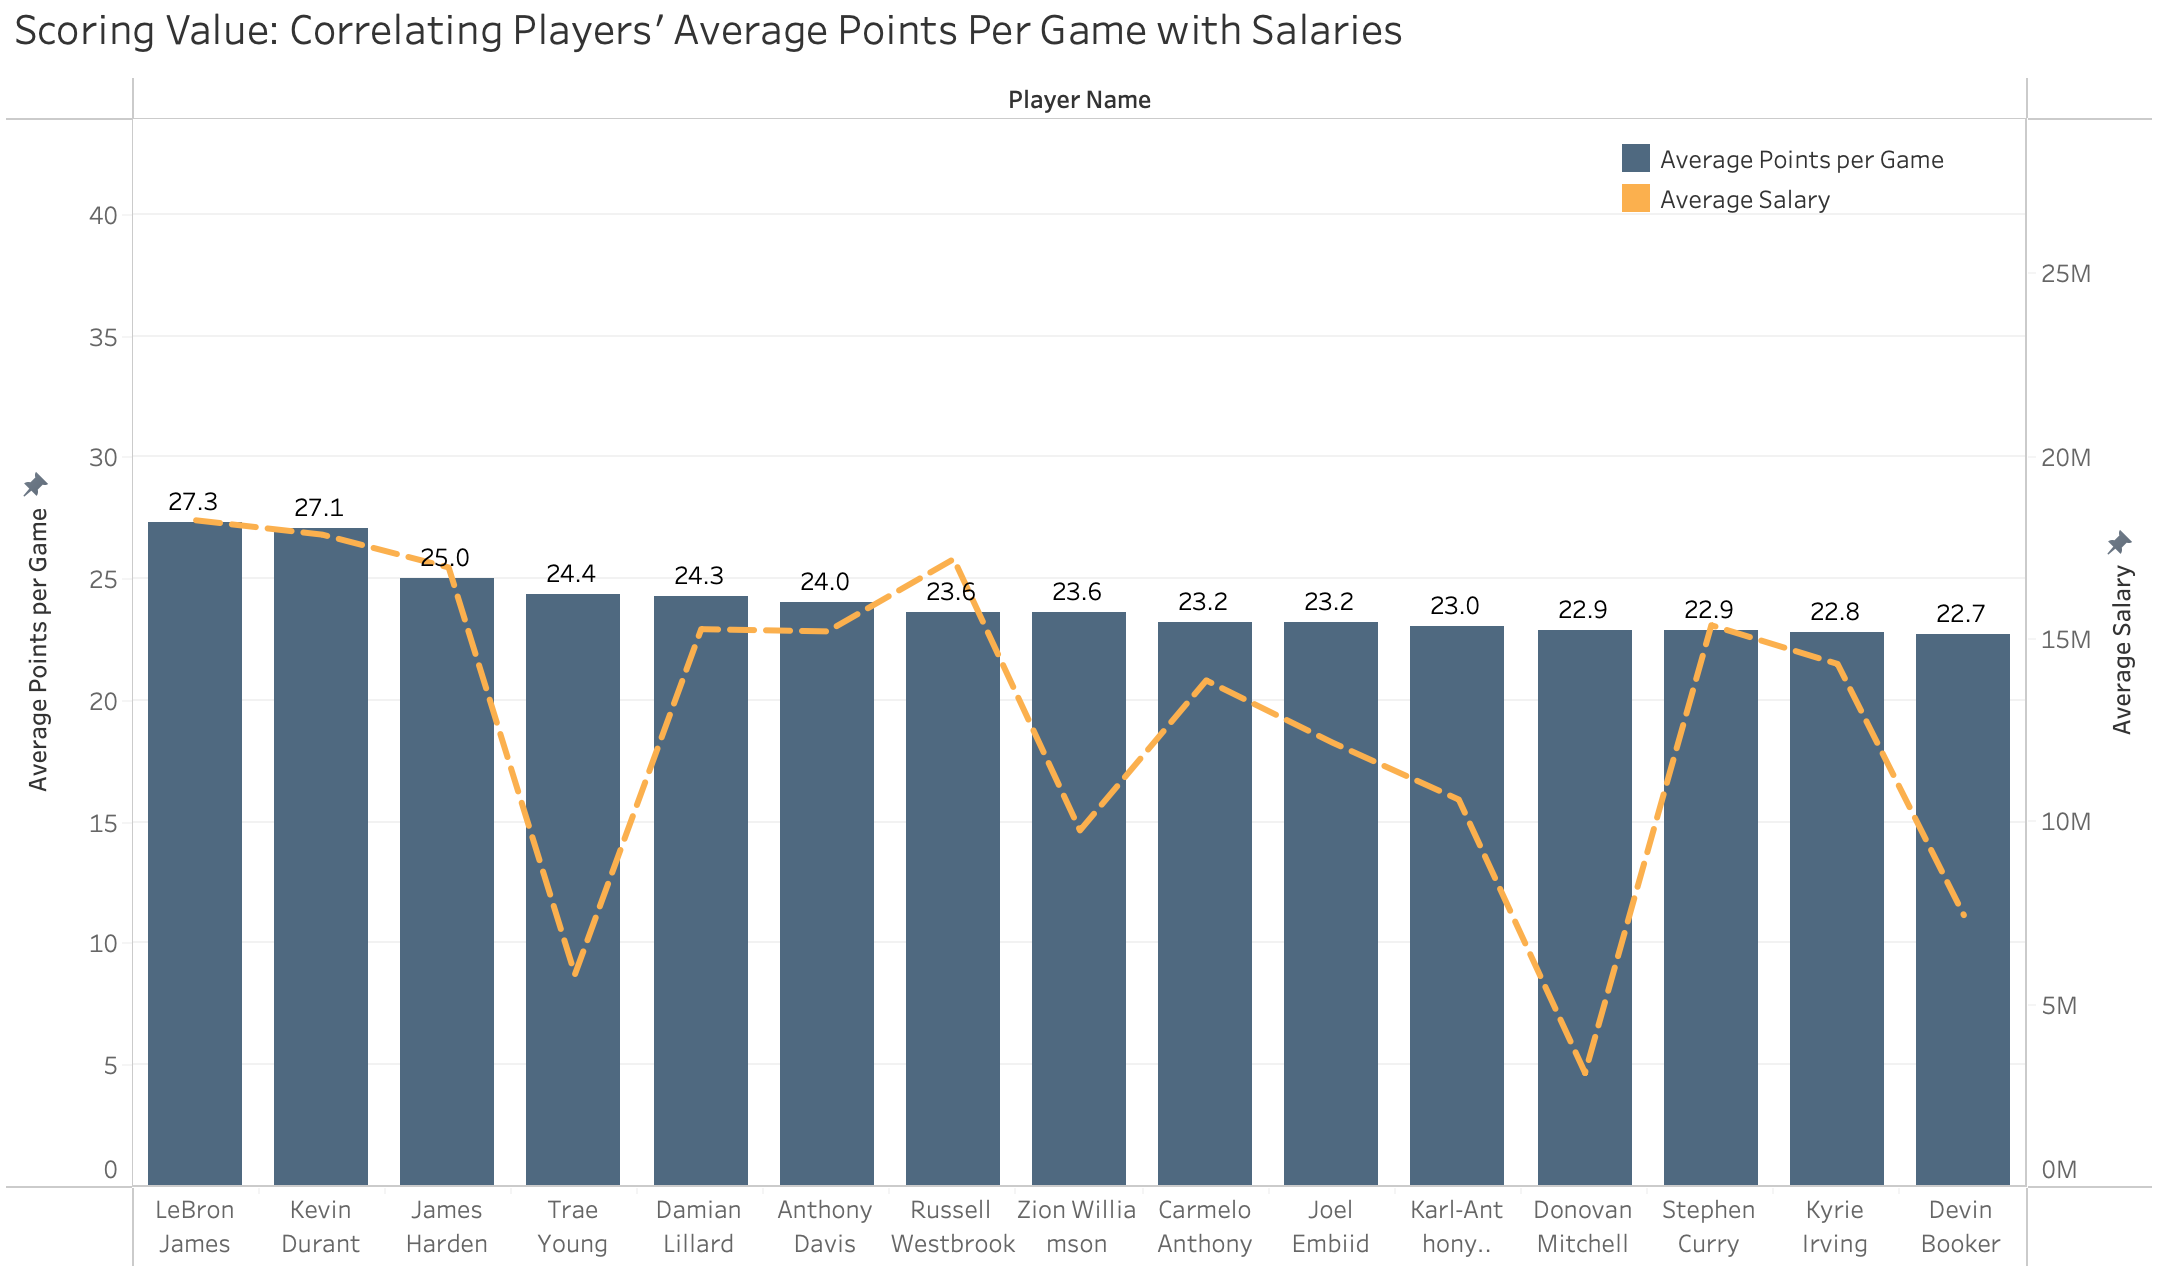

There's a visible trend where players with higher scoring averages tend to have larger salaries, as seen with stars like LeBron James and Kevin Durant. However, the correlation isn't absolute, with some players like Trae Young and Donovan Mitchel having low salaries compared to their scoring averages. This indicates that while scoring is a significant factor in salary determination, it's not the only one, with a player's brand, defensive skills, or other on-court contributions likely also playing critical roles in their valuation

## Team Analysis

**How do the various teams perform across the playoff season and the regular season?**


This query helps us analyze what is the ratio of win/lose across the two seasons- playoffs and regular. It also might help front offices understand which coaches and players actually have what it takes when the serious games come around.

In [ ]:
%%bigquery --project= teamb09
SELECT
    Team,
    SUM(CASE
        WHEN playoff_winloss_ratio > reagular_winloss_ratio THEN 1
        ELSE 0
    END) AS PlayOffGreaterReg,
    SUM(CASE
        WHEN playoff_winloss_ratio < reagular_winloss_ratio THEN 1
        ELSE 0
    END) AS RegGreaterPlayOff
FROM
    teamb09.kaggle.coaches_updated
GROUP BY
    Team
ORDER BY PlayOffGreaterReg DESC, RegGreaterPlayOff DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,Team,PlayOffGreaterReg,RegGreaterPlayOff
0,Los Angeles Lakers,9,22
1,Detroit Pistons,4,19
2,San Antonio Spurs,3,28
3,Houston Rockets,3,27
4,Chicago Bulls,3,27


It can be seen that the team 'LAL'- Los Angeles Lakers performed the best across both the seasons with a cumulative Win to Lose ratio of 9 in Play off season and 22 in Regular season.

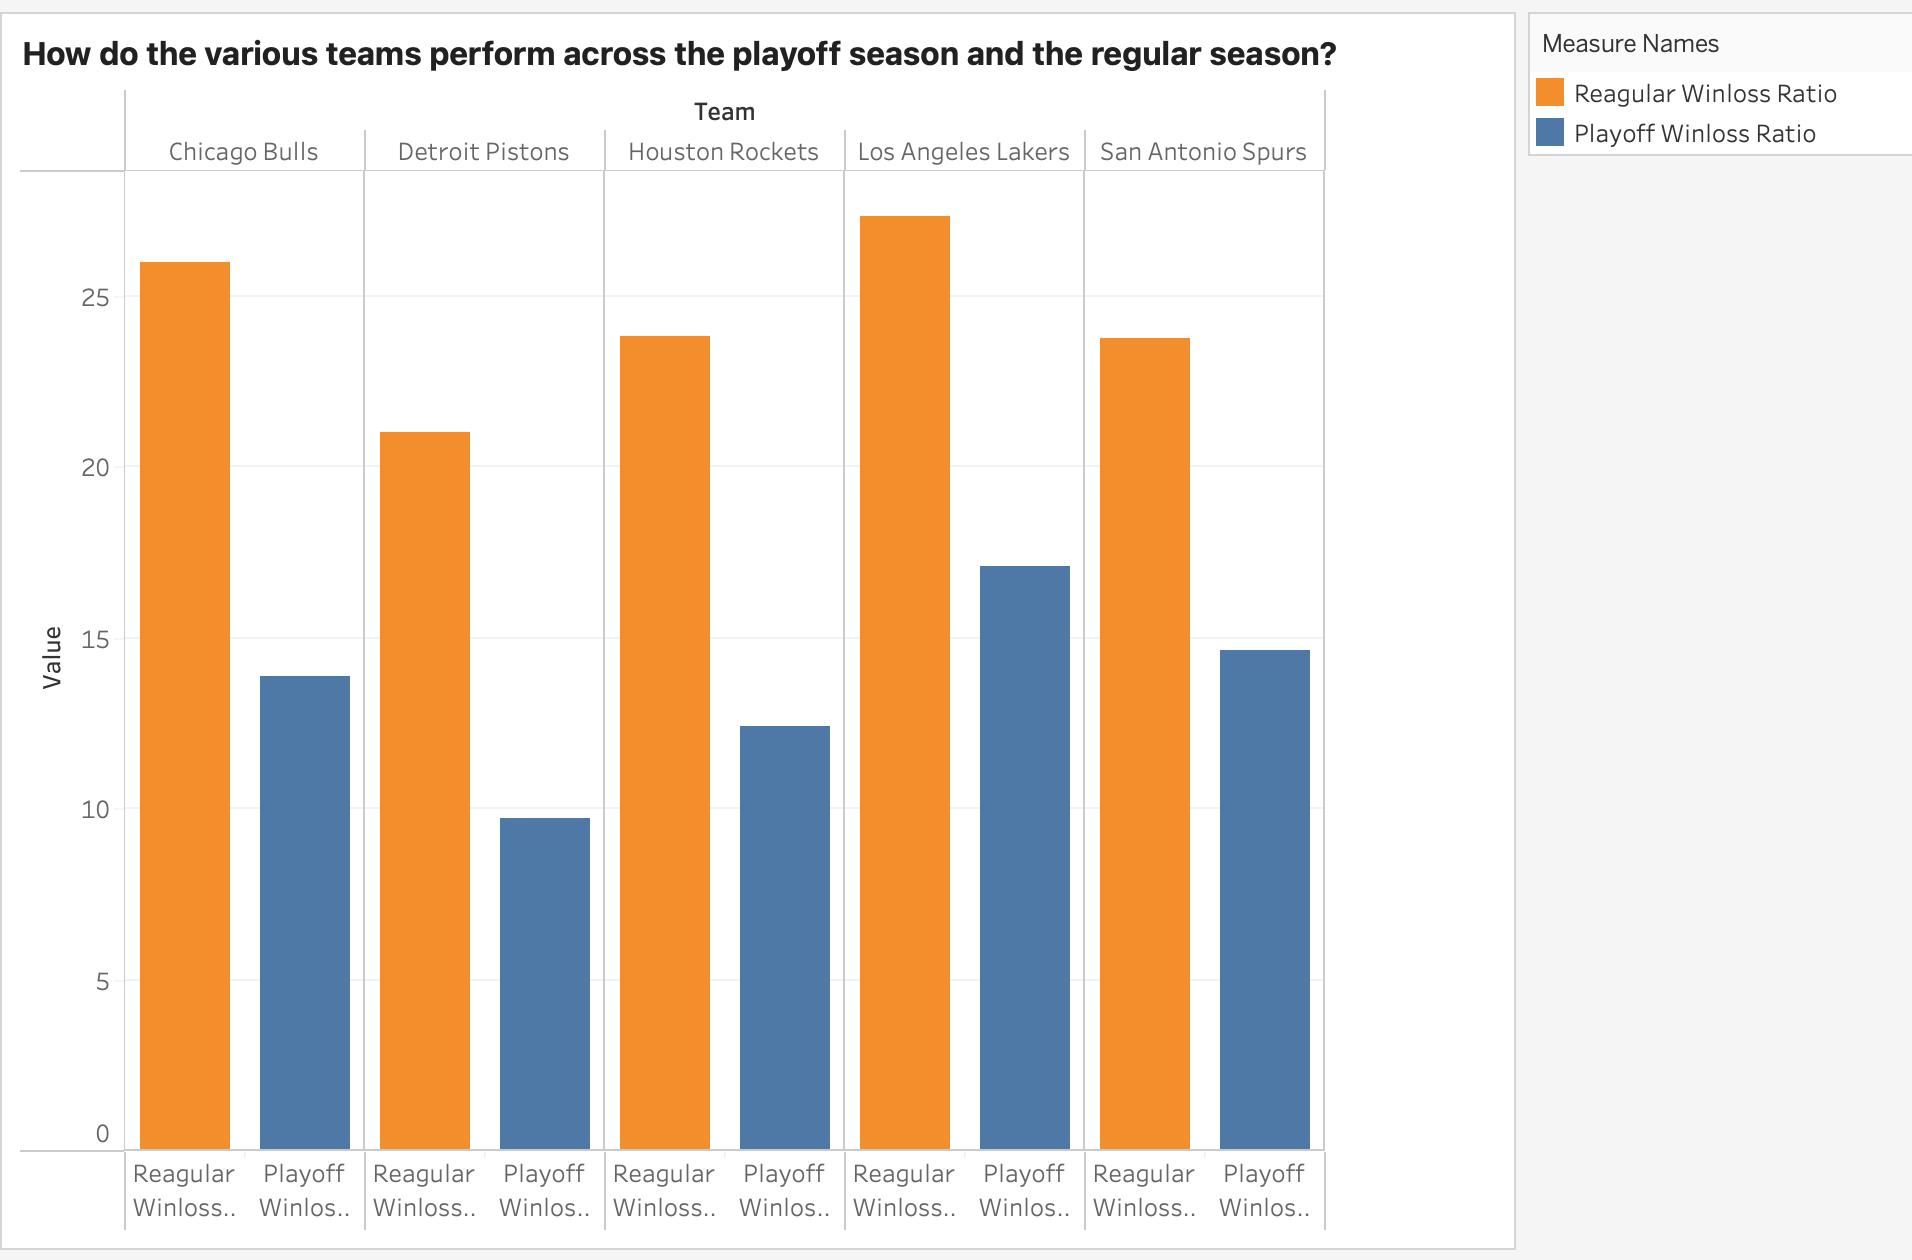

**Teams with Highest Average Attendance in Home Games (2010-2022)**

This query assesses the popularity and fan support for teams by analyzing average home game attendances. Higher attendance often correlates with team performance and fan engagement.

In [ ]:
%%bigquery --project=teamb09

SELECT homeTeam, AVG(attendance) as avgAttendance
FROM `teamb09.kaggle`.games
WHERE seasonStartYear BETWEEN 2010 AND 2022
GROUP BY homeTeam
ORDER BY avgAttendance DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,homeTeam,avgAttendance
0,Chicago Bulls,21323.851415
1,Dallas Mavericks,20066.455422
2,Miami Heat,19765.599109
3,Portland Trail Blazers,19735.252381
4,New York Knicks,19491.985149


The Chicago Bulls had the highest average attendance with `21,323`, followed by the Dallas Mavericks, Miami Heat, Portland Trail Blazers, and New York Knicks. This indicates that these teams likely had strong fan engagement during the specified period. These results are also supported by the appearance of teams such as the Bulls, Heat, and Knicks, which have some of the deepest and most dedicated fanbases in the league. Furtheremore, this could be correlated with the size of the arena that the teams play in.

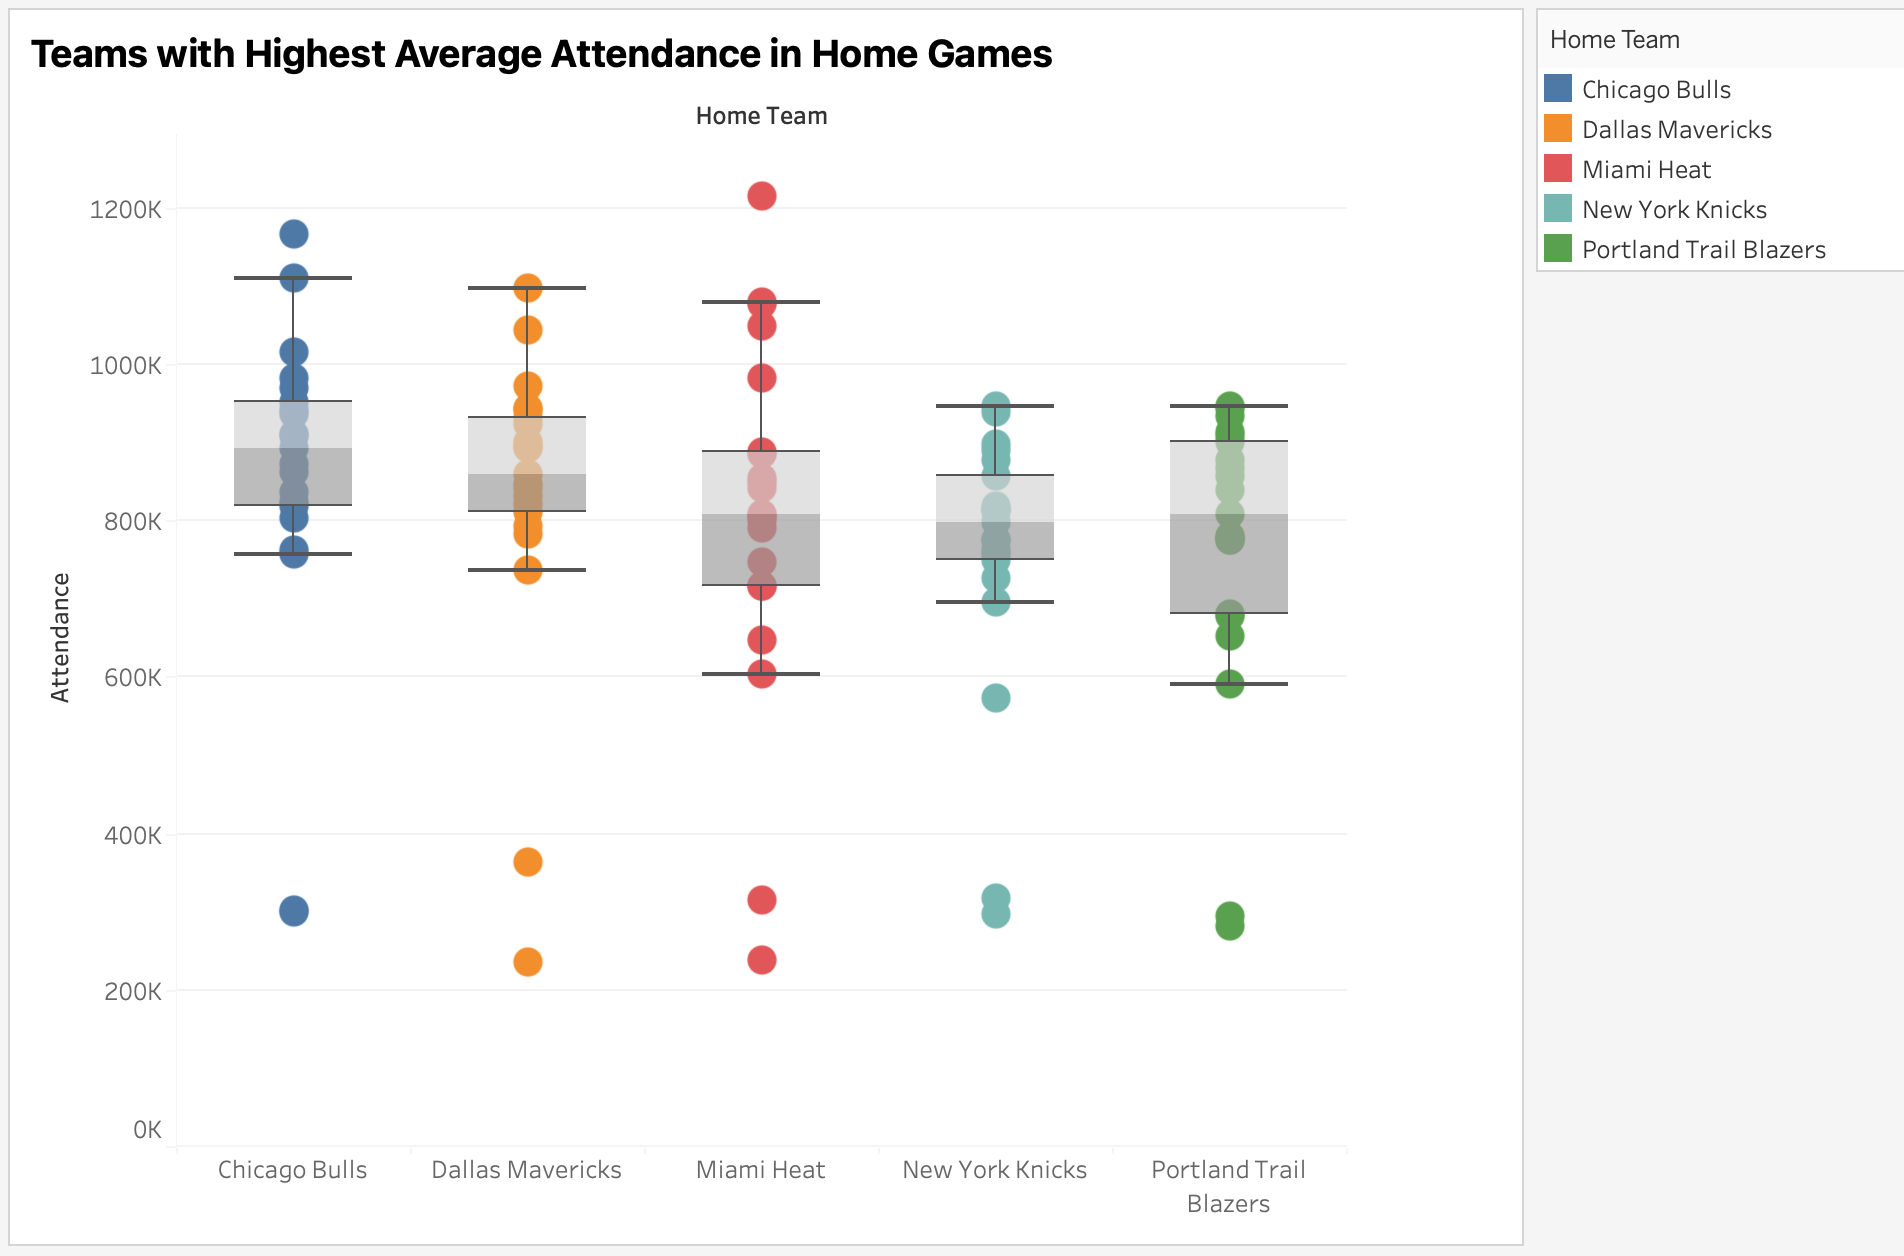

**What are the times of the day with the most exciting games?**

This SQL query retrieves information about the top 5 times of the day that have the highest-scoring games, based on the sum of points scored by both the away and home teams.

It helps identify and rank the times of the day when games are most exciting or have the highest scores, allowing us to pinpoint specific periods associated with intense or high-scoring basketball matches.

In [ ]:
%%bigquery --project=teamb09
SELECT startET, SUM(pointsAway + pointsHome) AS totalPoints
FROM `teamb09.kaggle.games`
GROUP BY startET
ORDER BY totalPoints DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,startET,totalPoints
0,8:00p,1015144
1,7:00p,963577
2,7:30p,723439
3,10:30p,530293
4,9:00p,486496


This is interesting, as the 8:00pm slot is usually the NBA primetime game. Usually the higher performing teams that are matched up for the week get this slot, so it would make sense that they're scoring more and that the games are more "exciting".

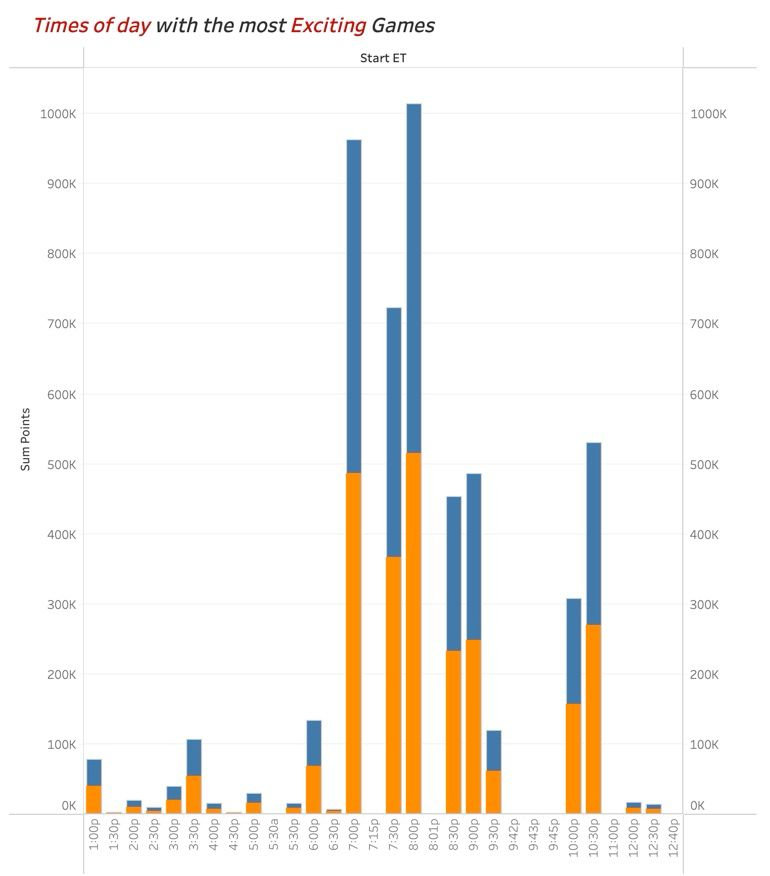

**Which coach have the Highest Win Percentage in Regular Games (2010-2022)?**

This query determines the most successful coaches based on their win percentage in regular games. It is a measure of a coach’s ability to lead their team to victory.

In [ ]:
%%bigquery --project=teamb09
--new query
SELECT c.Name as Name, count(Name) as season_num, SUM(regular_games_coached) as play_num, MAX((c.regular_season_wins / (c.regular_season_wins + c.regular_season_losses))) as maxWinPercentage
FROM `teamb09.kaggle`.coaches_updated AS c
GROUP BY c.Name
HAVING play_num>1000
ORDER BY maxWinPercentage DESC, play_num DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,Name,season_num,play_num,maxWinPercentage
0,Phil Jackson,20,1640,0.878049
1,Gregg Popovich,26,2024,0.817073
2,Doc Rivers,23,1755,0.804878
3,Erik Spoelstra,14,1092,0.804878
4,George Karl,27,1999,0.800000


From the data, Erik Spoelstra is the youngest coach with the fewest number of games, which is 1092 over 14 seasons, yet he ranks among the top 5 coaches with the highest win percentage. He is ranked fourth among senior coaches who have coached more than 1600 games, namely Phil Jackson, Gregg Popovich, Doc Rivers, and George Karl. Among these coaches, Gregg Popovich is the oldest active basketball coach which also listed as one of Hall of Fame NBA coaches.

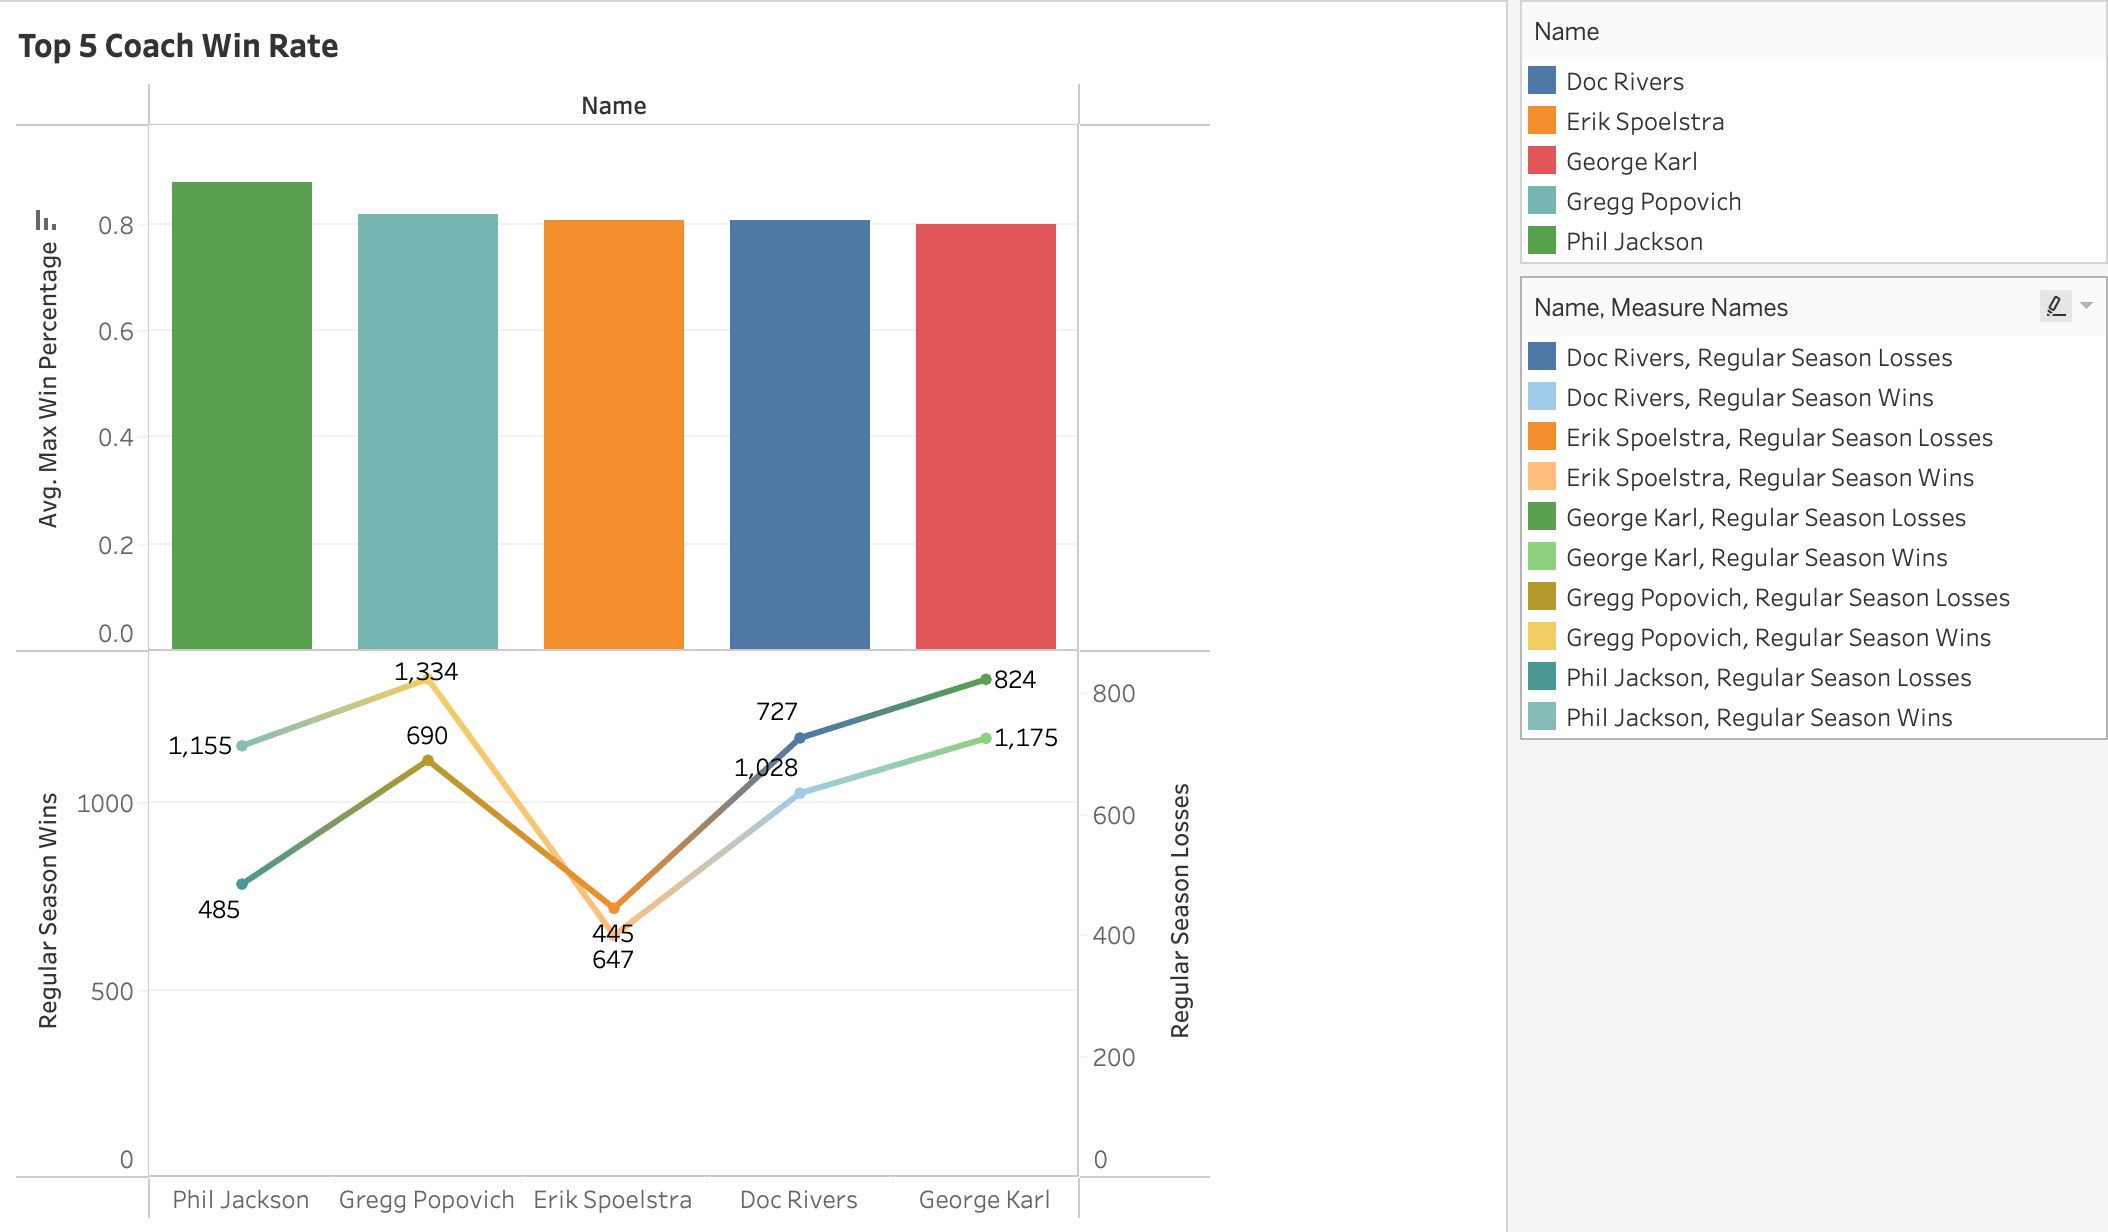

## Financial Analysis

**What are the top five players by salary, per season?**

Let's take a quick look at the per game stats for the highest paid players in each season. After we get this information, we'll be able to pair it with relative per game stats to see which players are undervalued or overvalued.

In [ ]:
%%bigquery --project= teamb09
WITH RankedSalaries AS (
    SELECT
        pgs.*,
        sc.salary,
        ROW_NUMBER() OVER (PARTITION BY pgs.Season ORDER BY sc.salary DESC) AS SalaryRank
    FROM
        `teamb09.kaggle.per_game_stats` AS pgs
    LEFT JOIN
        kaggle.salaries_cleaned AS sc
    ON
        pgs.Player = sc.playerName
)
SELECT *,
FROM RankedSalaries
WHERE SalaryRank <= 5;

Query is running:   0%|          |

Downloading:   0%|          |

,Player,Team,Season,PPG,APG,RPG,SPG,BPG,TPG,FGP,FTP,ThreePP,salary,SalaryRank
0,Chris Paul,New Orleans/Oklahoma City Hornets,2006,17.2,8.9,4.4,1.8,0.0,2.5,0.44,0.82,0.35,38506482.0,1
1,LeBron James,Cleveland Cavaliers,2006,26.9,6.4,7.0,1.6,0.7,3.2,0.46,0.71,0.31,37436858.0,2
2,Chris Paul,New Orleans/Oklahoma City Hornets,2006,17.2,8.9,4.4,1.8,0.0,2.5,0.44,0.82,0.35,35654150.0,3
3,LeBron James,Cleveland Cavaliers,2006,26.9,6.4,7.0,1.6,0.7,3.2,0.46,0.71,0.31,35654150.0,4
4,Kyle Lowry,Memphis Grizzlies,2006,5.6,3.2,3.1,1.4,0.1,1.2,0.37,0.89,0.38,33296296.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Stephen Curry,Golden State Warriors,2010,18.6,5.8,3.9,1.5,0.3,3.1,0.48,0.93,0.44,40231758.0,1
96,Chris Paul,New Orleans Hornets,2010,16.3,9.9,4.3,2.3,0.1,2.3,0.47,0.87,0.40,38506482.0,2
97,Russell Westbrook,Oklahoma City Thunder,2010,22.2,7.9,4.7,1.8,0.4,4.0,0.43,0.84,0.32,38506482.0,3
98,John Wall,Washington Wizards,2010,16.4,8.3,4.6,1.8,0.5,3.8,0.41,0.77,0.30,38199000.0,4


It can be seen that Chris Paul has been ranked first, in terms of salary drawn, followed by Russell Westbrook and LeBron James, on the second and third position, respectively, for the '08 season. It has to be noted that these values would differ across different seasons.

**What Players are Undervalued or Overvalued?**

This will be a super insightful query. By building off the previous query and comparing relative per game stats to relative salary, we can valuate players. For example, a player that has positive relative stats and positive or negative and negative, they are probably fairly valued. However, if a player has negative per game relative stats and a positive relative salary, they might be overvalued. The inverse of this would indicate the play is undervalued.

In [ ]:
%%bigquery --project= teamb09
-- get relative stats
WITH relative_stats AS (
  SELECT
    pgs.Player, pgs.Team, pgs.Season, pi.pos,
    ROUND(pgs.PPG - AVG(pgs.PPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_PPG,
    ROUND(pgs.APG - AVG(pgs.APG) OVER(PARTITION BY pgs.Season), 1) AS Relative_APG,
    ROUND(pgs.RPG - AVG(pgs.RPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_RPG,
    ROUND(pgs.SPG - AVG(pgs.SPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_SPG,
    ROUND(pgs.BPG - AVG(pgs.BPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_BPG,
    ROUND(pgs.TPG - AVG(pgs.TPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_TPG,
    ROUND(pgs.PPG - AVG(pgs.PPG) OVER(PARTITION BY pgs.Season), 1) AS Relative_PPG,
    ROUND(pgs.FGP - AVG(pgs.FGP) OVER(PARTITION BY pgs.Season), 1) AS Relative_FGP,
    ROUND(pgs.FTP - AVG(pgs.FTP) OVER(PARTITION BY pgs.Season), 1) AS Relative_FTP,
    ROUND(pgs.ThreePP - AVG(pgs.ThreePP) OVER(PARTITION BY pgs.Season), 1) AS Relative_ThreePP,
    ROUND(sc.Salary - AVG(sc.Salary) OVER(PARTITION BY pgs.Season), 2) AS Relative_Salary
  FROM `teamb09.kaggle.per_game_stats` AS pgs
  LEFT JOIN `teamb09.kaggle.player_info_cleaned` AS pi
  ON pgs.Player = pi.player_name
  LEFT JOIN `teamb09.kaggle.salaries_cleaned` AS sc
  ON pgs.Player = sc.playerName
),

-- Rank the Salaries
RankedSalaries AS (
    SELECT
        rs.*,
        sc.salary,
        ROW_NUMBER() OVER(PARTITION BY rs.Season ORDER BY sc.salary DESC) AS SalaryRank,
    FROM
        relative_stats AS rs
    LEFT JOIN
        `teamb09.kaggle.salaries_cleaned` AS sc
    ON
        rs.Player = sc.playerName
)

-- Compare relative stats and relative salary to the average to see if players are over or under valued.
SELECT *
FROM RankedSalaries;

Query is running:   0%|          |

Downloading:   0%|          |

,Player,Team,Season,pos,Relative_PPG,Relative_APG,Relative_RPG,Relative_SPG,Relative_BPG,Relative_TPG,Relative_PPG_1,Relative_FGP,Relative_FTP,Relative_ThreePP,Relative_Salary,salary,SalaryRank
0,James Harden,Houston Rockets,2019,G,24.5,5.2,2.3,1.0,0.4,3.2,24.5,0.0,0.1,0.0,8184555.21,38199000.0,45
1,James Harden,Houston Rockets,2019,G,24.5,5.2,2.3,1.0,0.4,3.2,24.5,0.0,0.1,0.0,7159399.21,38199000.0,47
2,James Harden,Houston Rockets,2019,G,24.5,5.2,2.3,1.0,0.4,3.2,24.5,0.0,0.1,0.0,31689649.21,38199000.0,49
3,LeBron James,Los Angeles Lakers,2019,F-G,15.8,8.4,3.8,0.5,0.0,2.7,15.8,0.1,-0.1,0.0,9270561.21,37436858.0,61
4,LeBron James,Los Angeles Lakers,2019,F-G,15.8,8.4,3.8,0.5,0.0,2.7,15.8,0.1,-0.1,0.0,14135049.21,37436858.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003006,Leandro Barbosa,Indiana Pacers,2011,G,-1.3,-0.6,-1.8,0.1,-0.5,-0.1,-1.3,0.0,0.0,0.1,-5029372.21,500000.0,54017
1003007,Leandro Barbosa,Indiana Pacers,2011,G,-1.3,-0.6,-1.8,0.1,-0.5,-0.1,-1.3,0.0,0.0,0.1,-238652.21,500000.0,54019
1003008,Keith Bogans,New Jersey Nets,2011,G-F,-4.9,-1.4,-1.8,-0.3,-0.5,-0.7,-4.9,-0.1,-0.3,0.0,-4990386.21,366931.0,54913
1003009,Keith Bogans,New Jersey Nets,2011,G-F,-4.9,-1.4,-1.8,-0.3,-0.5,-0.7,-4.9,-0.1,-0.3,0.0,-5471721.21,366931.0,54915


The results of this table are valuable for front office stakeholders. Depending on the need, you can navigate or filter the table to find overvalued players on your team that you might want to cut salary for or let go when contract negotiations come around. Additionally it's an excellent resource to scout undervalued talent.

**How has inflation affected salaries across various years in relation to player popularity?**

This bar chart explores the intersection of macroeconomics and professional sports by comparing average NBA player salaries and their inflation-adjusted counterparts from 2011 to 2019. The horizontal axis spans the years, while the vertical axis measures salaries in millions of dollars. The first set of bars reveals the salaries adjusted for inflation, offering a nuanced understanding of how economic factors have influenced player compensation, while the second set showcases raw fluctuations in annual average salaries. Peaks and troughs expose the correlation between economic conditions and player earnings, providing a succinct visual narrative of the intricate relationship between inflation and NBA salaries over the past decade.

This visual representation serves as a powerful lens into the financial dynamics of the NBA, illustrating how macroeconomic trends have shaped the earning potential of players. By juxtaposing average salaries with their inflation-adjusted counterparts, the chart provides a concise yet comprehensive narrative, appealing to sports enthusiasts, economists, and those intrigued by the interplay of finance and athletics.

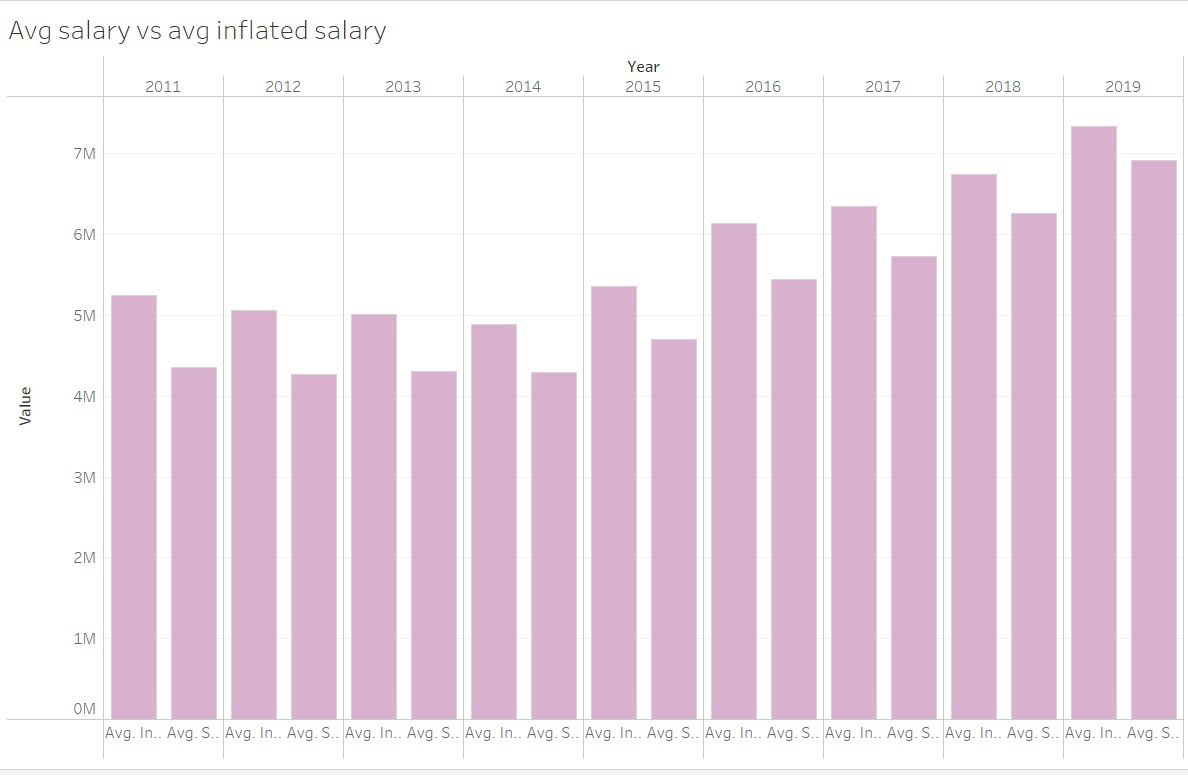

Burrowing deeper into the analysis pictured through the above plot, the aforementioned query helps analyze how inflation, across different season start year, affects the salary drawn by different players based on their popularity. It provides insights into how macroeconomic factors mingle with extensive fanbase of NBA players.

In [ ]:
%%bigquery --project=teamb09
SELECT DISTINCT(playerName), seasonStartYear, AVG(inflationAdjSalary) AS AvgInflationSalary,
FROM teamb09.kaggle.salaries_cleaned
GROUP BY seasonStartYear, playerName
ORDER BY seasonStartYear DESC, AvgInflationSalary DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,playerName,seasonStartYear,AvgInflationSalary
0,Stephen Curry,2019,42674629.0
1,Chris Paul,2019,40844595.0
2,Russell Westbrook,2019,40844595.0
3,John Wall,2019,40518442.0
4,James Harden,2019,40518442.0
...,...,...,...
11577,Stephen Howard,1996,314002.0
11578,Henry James,1996,314002.0
11579,Aaron Williams,1996,293022.0
11580,Robert Werdann,1996,287820.0


It can be seen that there is a huge difference between the average salaries drawn by players from 2019 to 1996, exhibiting how starkly the implications of infaltion have changed over the years. There has been a huge jump in the average salaries drawn, exmplafiying how inflation has changed the value of a dollar.

**Average Salaries of Top 5 Highest-Paid Players (2010-2022)**

This query provides insights into the financial aspects of the league, highlighting the top earners and their average salaries. It reflects the market value of elite players.

In [ ]:
%%bigquery --project=teamb09

SELECT playerName, ROUND(AVG(salary), 2) as avgSalary
FROM `teamb09.kaggle`.salaries_cleaned
WHERE seasonStartYear BETWEEN 2010 AND 2022
GROUP BY playerName
ORDER BY avgSalary DESC
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,playerName,avgSalary
0,Kobe Bryant,26142123.83
1,LeBron James,24809006.70
2,Chris Paul,23058352.20
3,Kevin Durant,21859077.20
4,Chris Bosh,20648922.22


Kobe Bryant was the highest-paid player on average with `26.1 million dollars`, followed by LeBron James, Chris Paul, Kevin Durant, and Chris Bosh.



**Analyzing Players with Most Triple-Doubles but Below Average Salaries**

This query enables us to identify players who have achieved the most triple doubles while earning a low salary (lower than the average for each season). This information is useful for teams in scouting for talent.

In [ ]:
%%bigquery --project=teamb09
--query for the player's with triple double
CREATE OR REPLACE TABLE teamb09.temp.triple_double
AS
SELECT boxscore.*, games.datetime,
FROM teamb09.kaggle.boxscore_cleaned AS boxscore
INNER JOIN teamb09.kaggle.games ON boxscore.game_id = games.game_id
WHERE
    ((boxscore.PTS>=10 AND boxscore.TRB>=10 AND boxscore.AST>=10) OR
    (boxscore.PTS>=10 AND boxscore.TRB>=10 AND boxscore.STL>=10) OR
    (boxscore.PTS>=10 AND boxscore.TRB>=10 AND boxscore.BLK>=10) OR
    (boxscore.PTS>=10 AND boxscore.AST>=10 AND boxscore.STL>=10) OR
    (boxscore.PTS>=10 AND boxscore.AST>=10 AND boxscore.BLK>=10) OR
    (boxscore.PTS>=10 AND boxscore.STL>=10 AND boxscore.BLK>=10) OR
    (boxscore.TRB>=10 AND boxscore.AST>=10 AND boxscore.STL>=10) OR
    (boxscore.TRB>=10 AND boxscore.AST>=10 AND boxscore.BLK>=10) OR
    (boxscore.TRB>=10 AND boxscore.STL>=10 AND boxscore.BLK>=10) OR
    (boxscore.AST>=10 AND boxscore.STL>=10 AND boxscore.BLK>=10))
ORDER BY games.datetime DESC;

--query for the player's salary under average
CREATE OR REPLACE TABLE teamb09.temp.low_salary
AS
SELECT playerName, seasonStartYear, salary, ROUND(avg_salary,2) AS avg_salary, ROUND(relative_salary,2) AS relative_salary
FROM
  (SELECT *, AVG(salary) OVER(PARTITION BY seasonStartYear) AS avg_salary, salary/AVG(salary) OVER(PARTITION BY seasonStartYear) AS relative_salary
  FROM teamb09.kaggle.salaries_cleaned
  ORDER BY playerName, seasonStartYear)
WHERE relative_salary<1;

--query to identify player's with triple double score, but paid under average salary
SELECT triple_double.*, low_salary.salary, low_salary.avg_salary, low_salary.relative_salary
FROM teamb09.temp.triple_double AS triple_double
INNER JOIN teamb09.temp.low_salary AS low_salary
ON triple_double.playerName = low_salary.playerName AND EXTRACT(YEAR FROM triple_double.datetime) = low_salary.seasonStartYear;


Query is running:   0%|          |

Downloading:   0%|          |

,game_id,teamName,playerName,MP_seconds,status,FG,FGA,ThreeP,ThreePA,FT,...,BLK,TOV,PF,PTS,plus_minus,isStarter,datetime,salary,avg_salary,relative_salary
0,29494,Miami Heat,Bam Adebayo,2249,Played,7,12,0,0,4,...,2,1,4,18,15,True,2019-12-14,3454080.0,6922103.41,0.50
1,29460,Miami Heat,Bam Adebayo,2611,Played,13,18,0,1,4,...,0,4,5,30,26,True,2019-12-10,3454080.0,6922103.41,0.50
2,29337,Atlanta Hawks,Trae Young,2483,Played,11,23,4,11,4,...,0,3,1,30,-4,True,2019-11-23,6273000.0,6922103.41,0.91
3,28984,New York Knicks,Mario Hezonja,2523,Played,6,11,0,3,4,...,0,4,3,16,-10,True,2019-04-05,1737145.0,6922103.41,0.25
4,28782,Atlanta Hawks,Trae Young,1719,Played,4,14,2,4,13,...,0,2,3,23,13,True,2019-03-09,6273000.0,6922103.41,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,5517,Los Angeles Clippers,Jeff McInnis,2619,Played,8,15,3,5,2,...,0,1,2,21,15,True,2001-03-16,590850.0,3463517.48,0.17
126,5006,Philadelphia 76ers,Aaron McKie,2855,Played,8,16,2,5,1,...,1,4,2,19,14,True,2000-12-30,1818000.0,3304928.99,0.55
127,4792,Los Angeles Clippers,Lamar Odom,2492,Played,6,12,1,1,3,...,1,6,3,16,26,True,2000-11-29,2628960.0,3304928.99,0.80
128,4766,Charlotte Hornets,Baron Davis,2481,Played,4,7,1,2,5,...,0,0,3,14,12,True,2000-11-25,2916000.0,3304928.99,0.88


It can be seen that Bam Adebayo has drawn a relatively lower salary while scoring the most triple doubles.


**Evaluating Players with Low Performance (High Fouls and Turnovers) but High Salaries (5 times higher than average salary)**

This query enables us to identify the player with the highest total of personal fouls and turnovers (low performance) who also has a high salary.

In [ ]:
%%bigquery --project=teamb09
--query to create table of players most high number of fouls and turnover
CREATE OR REPLACE TABLE `teamb09.temp.fouls_turnover`
AS
SELECT boxscore.game_id, boxscore.teamName, boxscore.playerName, boxscore.TOV, boxscore.PF, EXTRACT(YEAR FROM games.datetime) AS year
FROM teamb09.kaggle.boxscore_cleaned AS boxscore
INNER JOIN teamb09.kaggle.games ON boxscore.game_id = games.game_id
WHERE TOV IS NOT NULL AND PF IS NOT NULL
ORDER BY games.datetime DESC;

--query for the player's salary 5 times higher average
CREATE OR REPLACE TABLE teamb09.temp.high_salary
AS
SELECT playerName, seasonStartYear, salary, ROUND(avg_salary,2) AS avg_salary, ROUND(relative_salary,2) AS relative_salary
FROM
  (SELECT *, AVG(salary) OVER(PARTITION BY seasonStartYear) AS avg_salary, salary/AVG(salary) OVER(PARTITION BY seasonStartYear) AS relative_salary
  FROM teamb09.kaggle.salaries_cleaned
  ORDER BY playerName, seasonStartYear)
WHERE relative_salary>5;

--query to identify player's with low performance, but paid 5 times higher than average salary
SELECT fouls_turnover.*, high_salary.salary, high_salary.avg_salary, high_salary.relative_salary
FROM teamb09.temp.fouls_turnover AS fouls_turnover
INNER JOIN teamb09.temp.high_salary AS high_salary
ON fouls_turnover.playerName = high_salary.playerName AND fouls_turnover.year = high_salary.seasonStartYear
ORDER BY fouls_turnover.TOV desc, fouls_turnover.PF DESC, high_salary.relative_salary DESC, fouls_turnover.year DESC
LIMIT 100;

Query is running:   0%|          |

Downloading:   0%|          |

,game_id,teamName,playerName,TOV,PF,year,salary,avg_salary,relative_salary
0,27201,Cleveland Cavaliers,LeBron James,11,0,2018,35654150.0,6256553.48,5.70
1,28172,Oklahoma City Thunder,Russell Westbrook,10,5,2018,35665000.0,6256553.48,5.70
2,28621,Oklahoma City Thunder,Russell Westbrook,10,3,2019,38506482.0,6922103.41,5.56
3,28245,Detroit Pistons,Blake Griffin,10,3,2018,31873932.0,6256553.48,5.09
4,20118,Los Angeles Lakers,Kobe Bryant,10,2,2012,27849000.0,4274055.67,6.52
...,...,...,...,...,...,...,...,...,...
95,21932,New York Knicks,Carmelo Anthony,7,4,2014,22458401.0,4293242.99,5.23
96,7004,Utah Jazz,Karl Malone,7,4,2002,19250000.0,3702467.96,5.20
97,6476,Utah Jazz,Karl Malone,7,4,2002,19250000.0,3702467.96,5.20
98,4961,Washington Wizards,Juwan Howard,7,4,2000,16875000.0,3304928.99,5.11


The results here are interesting because all of these are high performing players. This might be a result of these players being the main ball handlers or main defensive players for their team. Since, they're the focal point in most of the plays during the game, it would make sense that they're recording more turnovers and fouls. A great example of this is Russell Westbrook. Westbrook handled the ball most of the time in OKC, which led to a lot of turnovers. However, he was still an exceptional player.

# Preping Data for Tableau

If we look at the query above that creates the per game stats for each NBA player, you'll notice that each stat has its own columns. While this makes sense in tabular form, Tableau will not be able to understand that these are all related and we won't be able to create meaningful visualizations. To get things ready for our dashboard, we actually will need to UNPIVOT the data. This will create the table in such a way that stat values are all in one column, and the stat names are all in one column. Furthermore, we'll attach some additional player information as well as salary so we don't need to make those relationships later in Tableau.

*Note that this query below will not run. There are lots of union alls, so to keep things tidy, the entire query is not below (rather a sample). Refer to the BigQuery database for the entire query.*

In [ ]:
%%bigquery --project=teamb09
WITH UnpivotedData AS (
  SELECT
    Player,
    Team,
    Season,
    'PPG' AS stat,
    PPG AS per_game,
    PERCENT_RANK() OVER (PARTITION BY Season ORDER BY PPG) AS percentile
  FROM
    kaggle.pgs

  UNION ALL

  SELECT
    Player,
    Team,
    Season,
    'FTP' AS stat,
    FTP AS per_game,
    PERCENT_RANK() OVER (PARTITION BY Season ORDER BY FTP) AS percentile
  FROM
    kaggle.pgs

  UNION ALL... -- Repeat this step for each per game stat you need inside the CTE

  )

  SELECT
    Player,
    Team,
    Season,
    stat,
    per_game,
    percentile
  FROM
    UnpivotedData
)

Next We do a similar process for the average stats per seasons

In [ ]:
%%bigquery --project=teamb09
SELECT
    Season,
    REPLACE(stat, 'avg_', '') AS stat,
    average
FROM
    (
        SELECT
            Season,
            avg_PPG,
            avg_APG,
            avg_RPG,
            avg_SPG,
            avg_BPG,
            avg_TPG,
            avg_FGP,
            avg_FTP,
            avg_ThreePP,
            avg_salary
        FROM kaggle.avg_stats_per_szn
    ) src
UNPIVOT
    (
        average FOR stat IN (
            avg_PPG,
            avg_APG,
            avg_RPG,
            avg_SPG,
            avg_BPG,
            avg_TPG,
            avg_FGP,
            avg_FTP,
            avg_ThreePP,
            avg_salary
        )
    ) unpiv

Query is running:   0%|          |

Downloading:   0%|          |

,Season,stat,average
0,2002,PPG,7.76
1,2002,APG,1.77
2,2002,RPG,3.54
3,2002,SPG,0.66
4,2002,BPG,0.42
...,...,...,...
195,2012,TPG,1.12
196,2012,FGP,0.43
197,2012,FTP,0.71
198,2012,ThreePP,0.28


Finally we create our datasource in Tableau as a custom SQL query so that are dashboard is fully functional with all the required data

In [ ]:
%%bigquery --project=teamb09
  SELECT Player, Team, Season, pos, birth_date, colleges, height_cm, weight_kg, Stat, per_game, percentile, average, ROUND(salary, 2) salary, ROUND(season_avg_salary, 2) season_avg_salary, from_year
  FROM `teamb09.kaggle.pgs_unpivot`
  LEFT JOIN kaggle.unpiv_avg_per_game_szns
  USING(Season, Stat)
  LEFT JOIN kaggle.player_eval
  USING(Player, Team, Season)

Query is running:   0%|          |

Downloading:   0%|          |

,Player,Team,Season,pos,birth_date,colleges,height_cm,weight_kg,Stat,per_game,percentile,average,salary,season_avg_salary,from_year
0,Cezary Trybański,Memphis Grizzlies,2002,None,NaT,None,NaN,NaN,ThreePP,NaN,0.000000,0.26,NaN,NaN,<NA>
1,D.J. Mbenga,Los Angeles Lakers,2007,None,NaT,None,NaN,NaN,ThreePP,NaN,0.000000,0.27,NaN,NaN,<NA>
2,Aleksandar Radojević,Denver Nuggets,2000,None,NaT,None,NaN,NaN,BPG,NaN,0.000000,0.42,NaN,NaN,<NA>
3,Zoran Planinić,New Jersey Nets,2002,None,NaT,None,NaN,NaN,APG,NaN,0.000000,1.77,NaN,NaN,<NA>
4,Levi Randolph,Cleveland Cavaliers,2019,None,NaT,None,NaN,NaN,PPG,NaN,0.000000,8.47,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99022,Luther Head,Sacramento Kings,2010,G,1982-11-26,Illinois,190.50,83.91,FTP,0.78,0.626812,0.72,1962378.0,6963952.74,2006
99023,James Anderson,San Antonio Spurs,2010,G-F,1989-03-25,Oklahoma State,198.12,96.62,FTP,0.78,0.626812,0.72,1463520.0,6963952.74,2011
99024,Devin Ebanks,Los Angeles Lakers,2010,F,1989-10-28,West Virginia,205.74,97.52,FTP,0.78,0.626812,0.72,1040000.0,6963952.74,2011
99025,Thabo Sefolosha,Oklahoma City Thunder,2010,G-F,1984-05-02,None,198.12,97.52,FTP,0.78,0.626812,0.72,5250000.0,6963952.74,2007


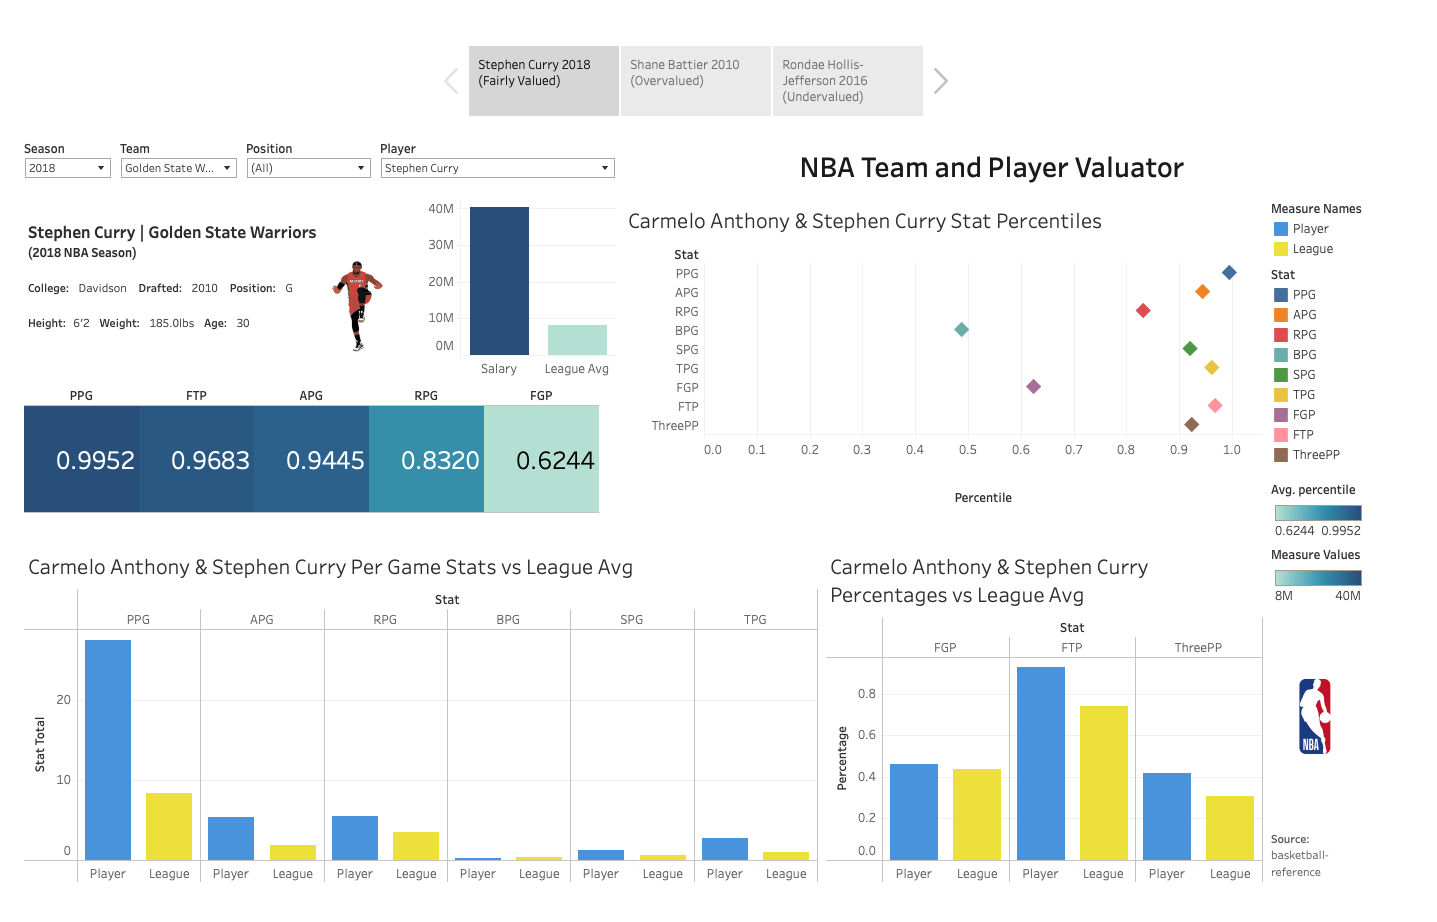

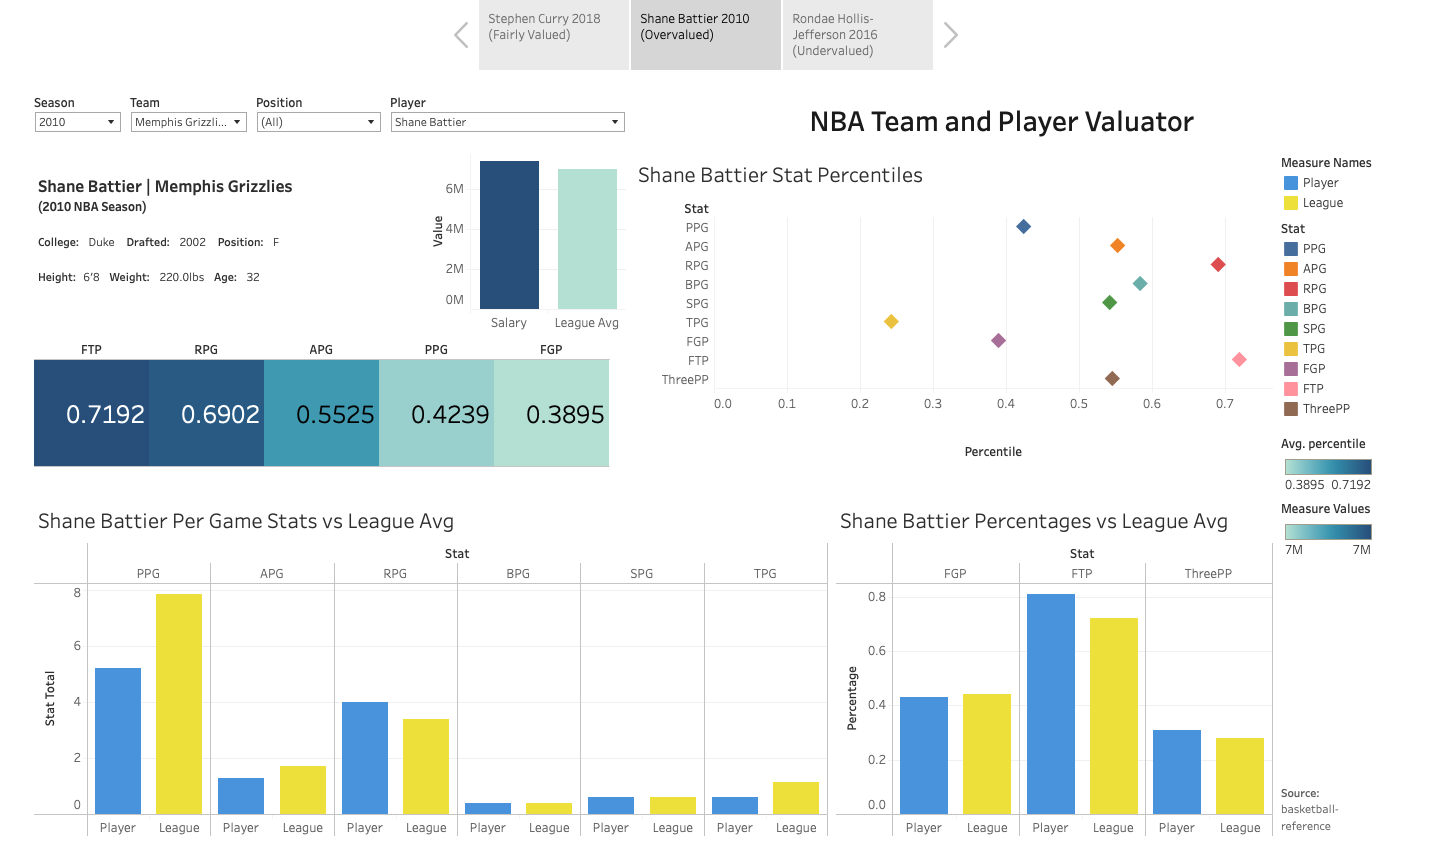

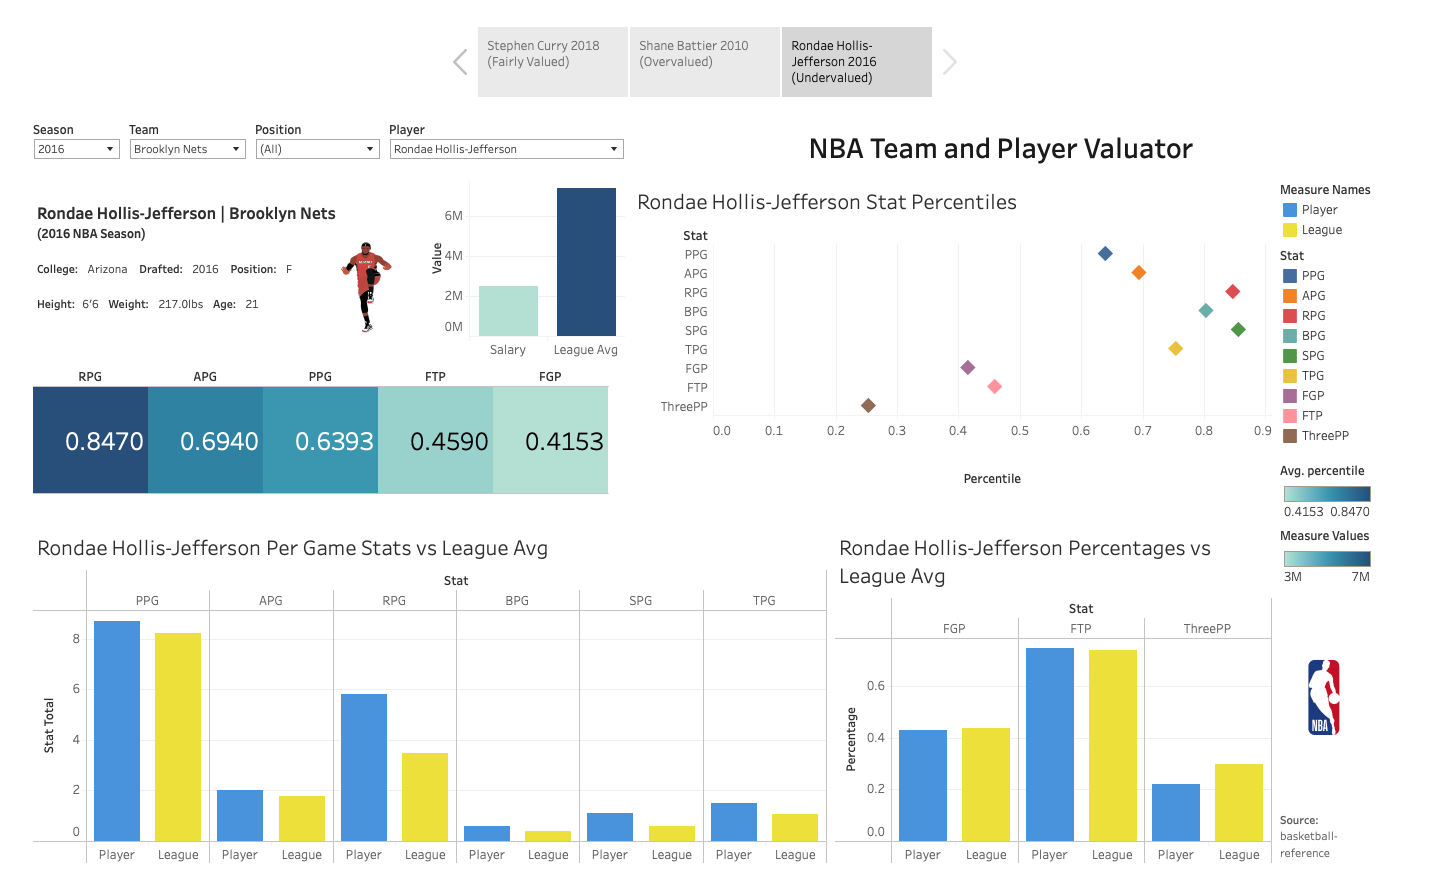

After we're done, this is what the [dashboard](https://public.tableau.com/app/profile/bennett.blanco8002/viz/nba-player-valuator-generic/NBAPlayerValuations?publish=yes) results to. The base function is to valuate players, but our data actually works out to where we can evaluate on the positional and team level. This means that the dashboard itself can actually be utilized by any actor (player, team, organization) be it for valuating a player, finding team weaknesses or player weaknesses, or defending your own value as a player.

# Key Findings and Conclusion

If we take a step back and look at the queries in the EDA section, we managed to better understand players, teams, and financials.

<br/>

**Business Value of player queries:**

The player queries can be utilized by opposing teams and front offices. For example, the top defensive players query can help coaches plan their matchups ahead of time so that the team will be able to make the proper adjustments when they have to play that team with the specific player. For a front office or media use case example, the players with the top per game stats query can be utilized to schedule primetime game slots.

<br/>

**Business Value of Team queries:**

The team queries can be utilized by the teams and front offices themselves, and the NBA as an organization. For example, a top 5 team in average attendance like the Knicks might want to use this information to continue utilizing their current marketing strategies or pricing in order to maintain that metric.

<br/>

**Business Value of Financial queries:**

The Financial queries are very useful for front office operations. The information provided by these can help make data-driven financial decsions. For example, the relative per game stats and relative salary query allows front offices to see what players are underperforming or overperforming based on their current salary. It's a great way to narrow down what players you are looking at in the trade window or in the free agency.

<br/>

**Dashboard Value**
Considering the capabilities of the dashboard, we have already mentioned that there is use on the Player, Team and Organizaitonal level. Though the dashboard only reaches 2019 (due to the limitations of the data), it serves as an excellent proof of concept to be utilized on current and future data. This will allow data informed decision making at all levels of the NBA.

# References

- [Kaggle Dataset](https://www.kaggle.com/datasets/patrickhallila1994/nba-data-from-basketball-reference?select=games.csv)
- [Webscraped Data](https://runrepeat.com/nba-revenue-statistics )
- [Alter Table Syntax (Snowflake)](https://docs.snowflake.com/en/sql-reference/sql/alter-table)
- [Alter Table Syntax (Clickhouse)](https://clickhouse.com/docs/en/sql-reference/statements/alter/update)
- [ERD Tool](https://lucid.app/lucidchart/560acb97-6357-459f-aed5-5e5ab3bac00e/edit?beaconFlowId=2E24D32C1C856A09&invitationId=inv_5dfea48b-1477-4e9b-8c8e-937dde7248a6&page=0_0#)




# Data Dictionaries

**`boxscore`**

| Field Name            | Description                                       |
|------------------------|---------------------------------------------------|
| game_id (Game ID)      | A unique identifier for each game.                |
| teamName (Team Name)    | The name of the team that the player is associated with. |
| playerName (Player Name)| The name of the player.                           |
| MP (Minutes Played)     | The total minutes the player played in the game.  |
| FG (Field Goals Made)   | The number of field goals made by the player.     |
| FGA (Field Goal Attempts)| The number of field goal attempts by the player.  |
| ThreeP (3-Points Made)      | The number of 3-point field goals made by the player. |
| ThreePA (3-Point Attempts)   | The number of 3-point field goal attempts by the player. |
| FT (Free Throws Made)    | The number of free throws made by the player.     |
| FTA (Free Throw Attempts)| The number of free throw attempts by the player.  |
| ORB (Offensive Rebounds)| The number of offensive rebounds secured by the player. |
| DRB (Defensive Rebounds)| The number of defensive rebounds secured by the player. |
| TRB (Total Rebounds)    | The total number of rebounds secured by the player.|
| AST (Assists)           | The number of assists made by the player.         |
| STL (Steals)            | The number of times the player stole the ball.    |
| BLK (Blocks)            | The number of shots blocked by the player.        |
| TOV (Turnovers)         | The number of times the player turned over the ball. |
| PF (Personal Fouls)     | The number of personal fouls committed by the player. |
| PTS (Points)            | The total points scored by the player.            |
| +/- (Plus/Minus)        | The player's plus/minus statistic.                |
| isStarter (Is Starter)  | Indicates if the player was a starter for the game.|

**`coaches`**

| Column Name | Description |
|-------------|-------------|
| Team                     | Represents the abbreviation or code for the NBA team.                            |
| League                  | Indicates the league affiliation, which is NBA (National Basketball Association) in this case. |
| regular_winloss_ratio (Win-Loss Ratio in the Regular Season) | Represents the team's performance in the regular season, indicating the ratio of wins to total games played. |
| playoff_winloss_ratio (Win-Loss Ratio in the Playoffs) | Represents the team's performance in the playoff season, indicating the ratio of wins to total playoff games played. |
| Accolade                        | notes about the team's performance, achievements, or notable events. |
| Name                    | Specifies the name of the head coach leading the team during a particular season. |
| Coach_id                     | Represents a unique identifier for the coach.                                   |
| seasonStartYear              | Indicates the starting year of the NBA season.                                   |
| role                    | Specifies the role or type of coaching position, such as "Head Coach."          |
| season_rank                       | Represents the finishing position or rank of the team in a particular season.   |
| playoff_games_coached | Indicates the total number of playoff games played under the coach in a season |
| playoff_wins  | Represents the number of playoff games won by the team under the coach in a season    |
| playoff_losses  | Represents the number of playoff games lost by the team under the coach in a season   |
| Age                          | Refers to the age of the head coach during a particular season.                 |
| regular_games_coached  | Indicates the total number of regular-season games played by the team under the coach in a season |
| regular_season_wins  | Represents the number of regular-season games won by the team under the coach in a season |
| regular_season_losses  | Represents the number of regular-season games lost by the team under the coach in a season |
| W500                         | Indicates whether the team had a win-loss ratio greater than .500 (W500 > .500), suggesting a winning record in the regular season. |


**`Player_info`**

| Column Name | Description |
|-------------|-------------|
| player_name | The name of the player |
| from_year | The player's first year in the NBA |
| to_year | The player's last year in the NBA |
| pos | The player's position that they play |
| height_cm | The player's height measured in centimeters |
| weight_kg | The player's weight measured in kilograms |
| birth_date | The player's date of birth |
| colleges | Which college the player attended (if null they either came from high school or international play) |

**`salaries`**

| Column Name | Description |
|-------------|-------------|
| playerName (Player Name)| The name of the player.                               |
| seasonStartYear (Season Year)| The year of the season for which the salary is applicable. |
| salary (Salary)         | The salary earned by the player for the season.       |
| inflationAdjSalary (Inflation Adjusted Salary)| The player's salary adjusted for inflation to reflect current value comparison. |


**`jersey_patch_sponsorships`**

| Column Name | Description |
|-------------|-------------|
| Team | Team name |
| jersey_rev_mil | Estimate of revenue generated by sponsorships (since inception)

**`operating_income`**

| Column Name | Description |
|-------------|-------------|
| Team | Team name |
| Year | Year of finances |
| Operating Income | Operating Income ($ Mil) |

**`rev_by_team`**

| Column Name | Description |
|-------------|-------------|
| Team | Team name |
| Year | Year of finances |
| Revenue | Revenue ($ Mil) |

**`ticket_revenue`**

| Column Name | Description |
|-------------|-------------|
| Team | Team name |
| Year | Year of finances |
| Ticket Revenue | Average revenue per ticket ($) |

**`team_abrev`**

| Column Name | Description |
|-------------|-------------|
| Team | Team name |
| Abbreviation | Three letter abbreviation for Team |